# Set-up MLFlow

In [1]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.8/672.8 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.5 MB/s eta 0:00:00


In [2]:
import mlflow

## Connect storage

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir mlflow_results

In [8]:
# To use MLFlow on Colab, we need to connect storage. We will use Google Drive

# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [9]:
# Set up experiment name
mlflow.set_experiment("Demand Forecast New Task")

2025/03/11 16:27:28 INFO mlflow.tracking.fluent: Experiment with name 'Demand Forecast New Task' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_results/254326668772453450', creation_time=1741710448496, experiment_id='254326668772453450', last_update_time=1741710448496, lifecycle_stage='active', name='Demand Forecast New Task', tags={}>

## Start MLFlow UI

In [10]:
!pip install pyngrok --quiet

In [12]:
from pyngrok import ngrok, conf
import getpass
import subprocess

In [13]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [14]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel "https://b3b1-34-23-36-223.ngrok-free.app" 


# Import all libraries we will need for the modeling and evaluation

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import mlflow.pyfunc
import mlflow.models
from mlflow.models.signature import infer_signature
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb


# Read the files with pandas

Hint: In the course we always load raw data and apply various transformation on it. To save time, you can create a notebook with data processing pipeline and store the output in final csv file. Later you simply read this preprocessed data in another notebook, where you work on the model. In this way you don't need to wait till data preprocessing is done every time you run the notebook to train the model and it will help you to ensure consistency if you train several models, without the need to copy-paste the code for data processing every time.

In [16]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

## Read the sales history for a few items in the state 'Pichincha'

In [17]:
# Get the list of store IDs for the state 'Guayas'
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
#Select the same items as for "Classical methods":
item_ids = [106716, 1158720]
#Select data before April'14
max_date = '2014-04-01'

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

# Group by date and aggregate sales
df_filtered = df_filtered.groupby(['store_nbr','item_nbr','date']).sum()['unit_sales'].reset_index()

<ipython-input-17-7640102a9c15>:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


In [18]:
df_filtered.shape

(6659, 4)

In [35]:
df_filtered.nunique()


store_nbr      10
item_nbr        2
date          453
unit_sales    223
dtype: int64

## Feature engineering

## Fill out missing dates with 0 sales

In [23]:
import pandas as pd

# Convert 'date' column to datetime format
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Create an empty DataFrame to store the final result
df_filled = pd.DataFrame()

# Iterate through each store and item combination
for (store, item), group in df_filtered.groupby(['store_nbr', 'item_nbr']):
    # Get the minimum and maximum dates in the dataset to create a full date range
    min_date = group['date'].min()
    max_date = group['date'].max()
    #print(min_date.date(), max_date.date())

    # Create a full date range covering all days between the min and max dates
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Set 'date' as index and sort by date
    group.set_index('date', inplace=True)
    group = group.sort_index()

    # Reindex to fill missing dates with 0 sales
    group = group.reindex(full_date_range, fill_value=0)

    # Keep track of the store and item number for each row
    group['store_nbr'] = store
    group['item_nbr'] = item

    # Ensure that missing sales values are filled with 0
    group['unit_sales'] = group['unit_sales'].fillna(0)

    # Append the group to the final DataFrame
    df_filled = pd.concat([df_filled, group])

# Reset the index to get 'date' back as a column
df_filled.reset_index(inplace=True)
df_filled.rename(columns={'index': 'date'}, inplace=True)

## Add more time-based features

In [25]:
df_filled['month'] = df_filled['date'].dt.month
df_filled['day'] = df_filled['date'].dt.day
df_filled['weekofyear'] = df_filled['date'].dt.isocalendar().week
df_filled['dayofweek'] = df_filled['date'].dt.dayofweek
df_filled['rolling_mean'] = df_filled['unit_sales'].rolling(window=7).mean()
df_filled['rolling_std'] = df_filled['unit_sales'].rolling(window=7).std()


# Create lag features (e.g., sales from the previous day, previous week)
df_filled['lag_1'] = df_filled['unit_sales'].shift(1)
df_filled['lag_7'] = df_filled['unit_sales'].shift(7)
df_filled['lag_30'] = df_filled['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filled.dropna(inplace=True)

# Add features related to stores and items

In [26]:
# Merge df_filtered with df_store and df_item on store_nbr and item_nbr, respectively
df_filled = df_filled.merge(df_stores, on='store_nbr', how='left').merge(df_items, on='item_nbr', how='left')

from sklearn.preprocessing import LabelEncoder
# Apply label encoding to each categorical column
le = LabelEncoder()
for col in ['city', 'state', 'type', 'family', 'class']:
    df_filled[col] = le.fit_transform(df_filled[col])

df_filled = df_filled.sort_values(by=['store_nbr', 'item_nbr', 'date'])

# Split in test and train datasets

In [27]:
split_date = '2014-03-01'
train = df_filled[df_filled['date'] < split_date]
test = df_filled[df_filled['date'] >= split_date]
print("Train dataframe shape:",train.shape)
print("Test dataframe shape:",test.shape)

Train dataframe shape: (6771, 20)
Test dataframe shape: (617, 20)


# ML model with XGBoost


In [45]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

In [46]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, enable_categorical=True)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

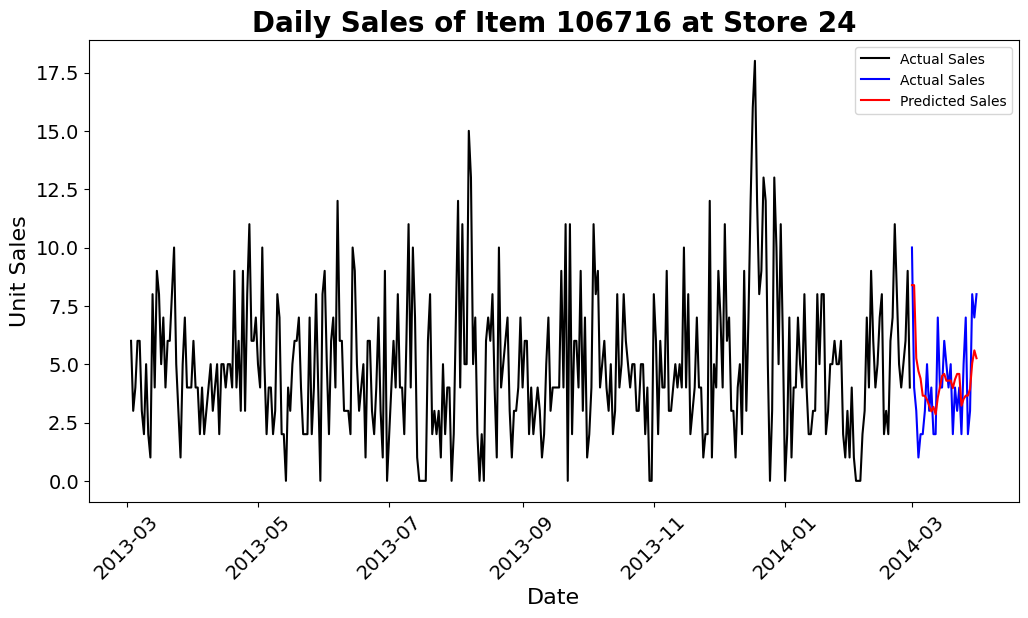

Metrics for Item 106716 and Store 24:
Bias: 0.1292590864243046
RMAD: 1.572783262498917
RMSE: 1.9158839361523994


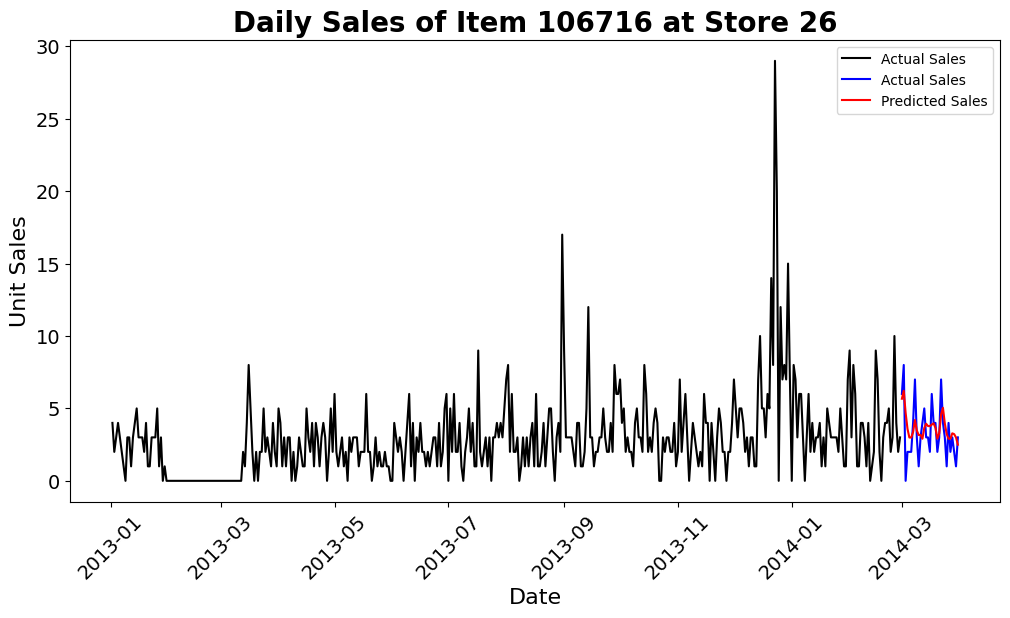

Metrics for Item 106716 and Store 26:
Bias: 0.31959852095573177
RMAD: 1.255435005311043
RMSE: 1.5750047621103338


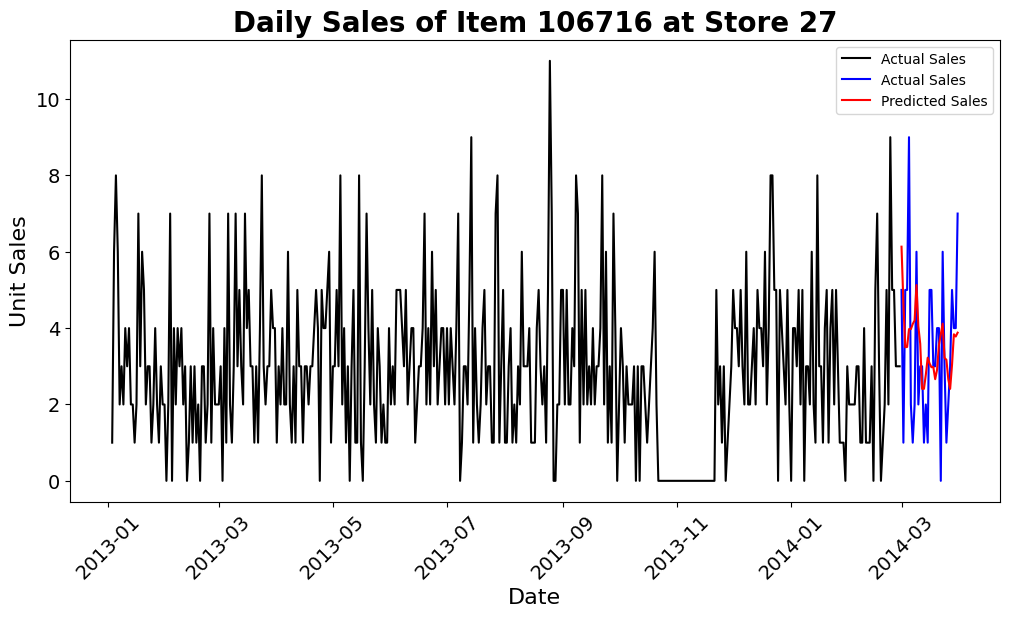

Metrics for Item 106716 and Store 27:
Bias: 0.088895813111336
RMAD: 1.5897695787491337
RMSE: 1.9903484824517768


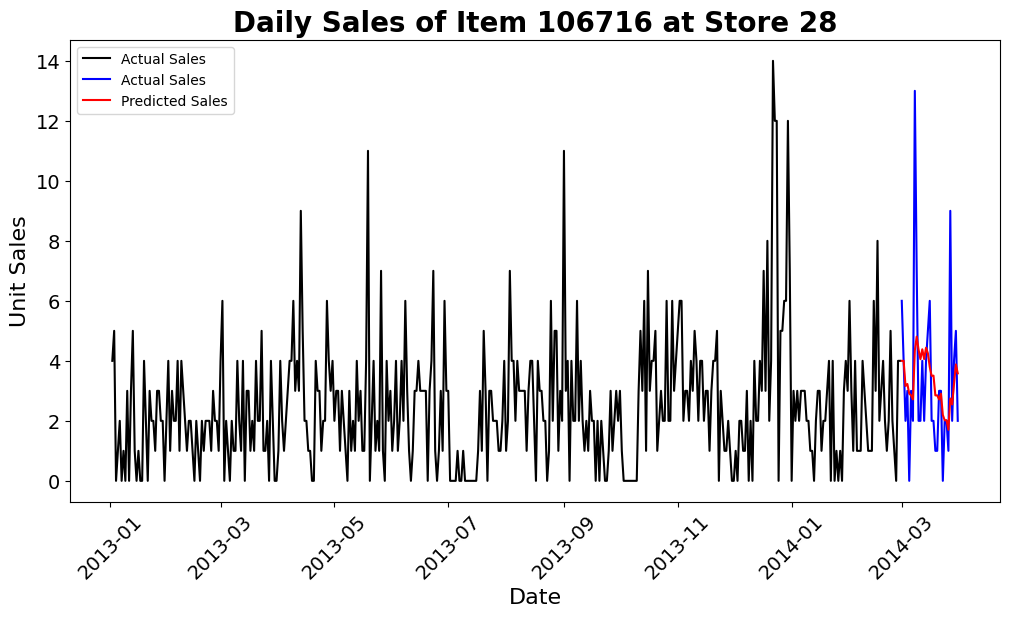

Metrics for Item 106716 and Store 28:
Bias: -0.012370124939949281
RMAD: 1.5665884017944336
RMSE: 2.372475527110326


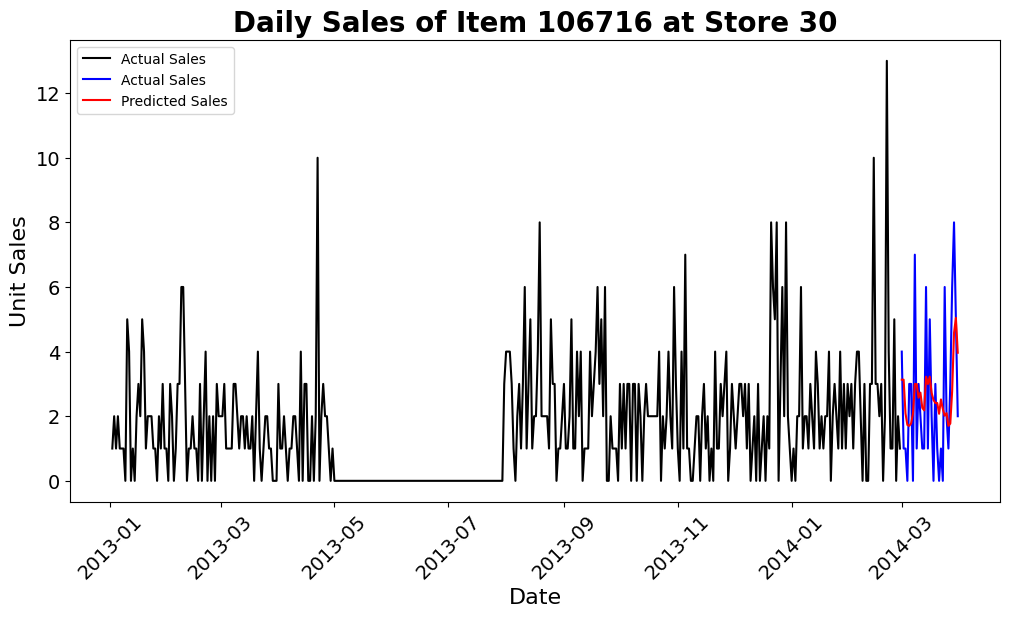

Metrics for Item 106716 and Store 30:
Bias: 0.08519849469584803
RMAD: 1.6858880442957724
RMSE: 1.9674588073076174


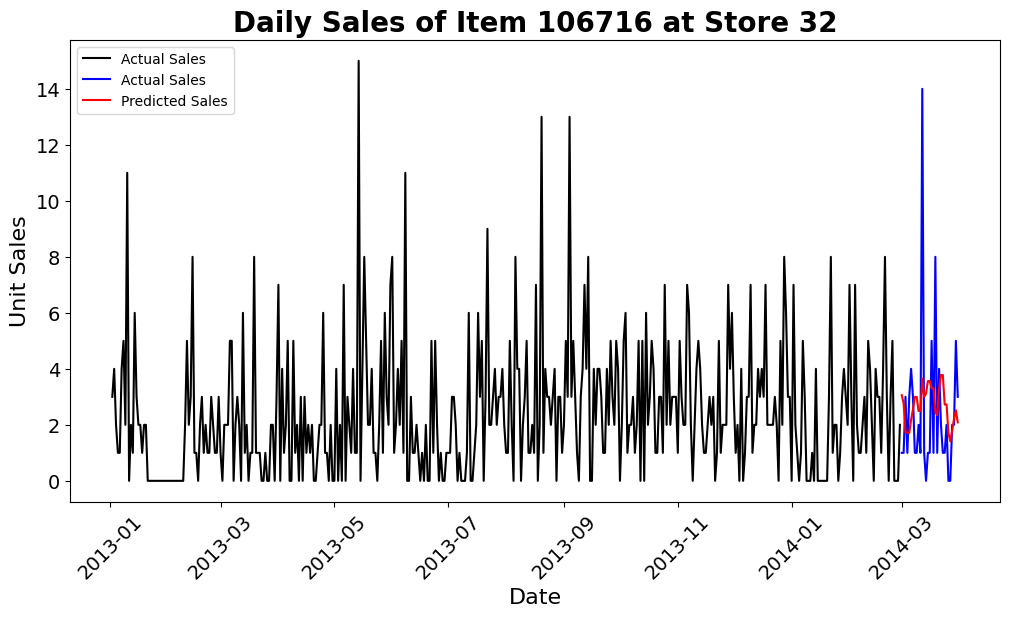

Metrics for Item 106716 and Store 32:
Bias: 0.26039904548275855
RMAD: 1.984016106974694
RMSE: 2.7034669633270245


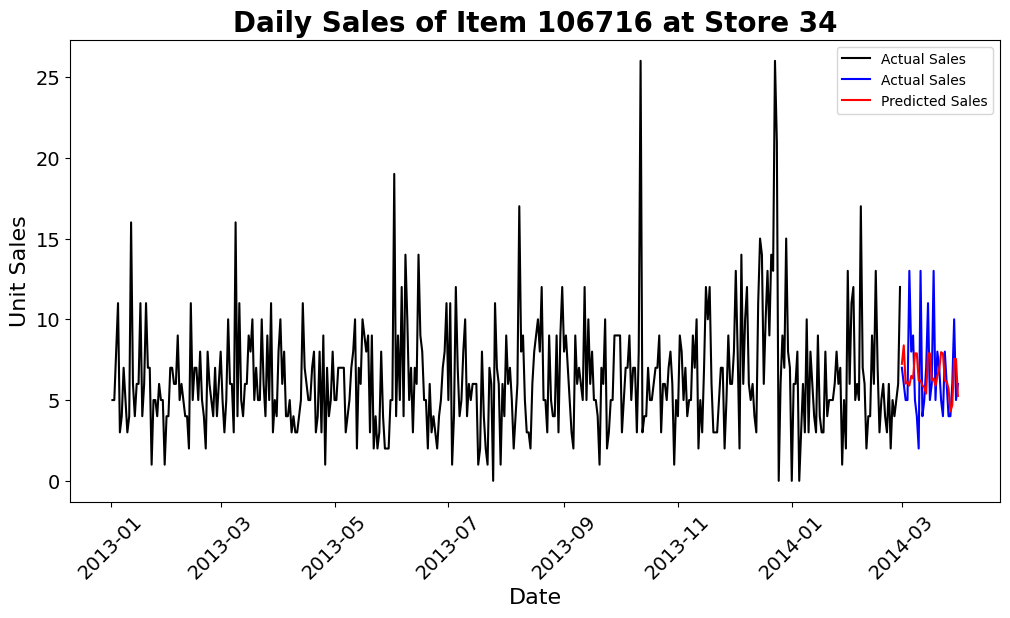

Metrics for Item 106716 and Store 34:
Bias: -0.10942226840603736
RMAD: 2.303154468536377
RMSE: 2.965014642551292


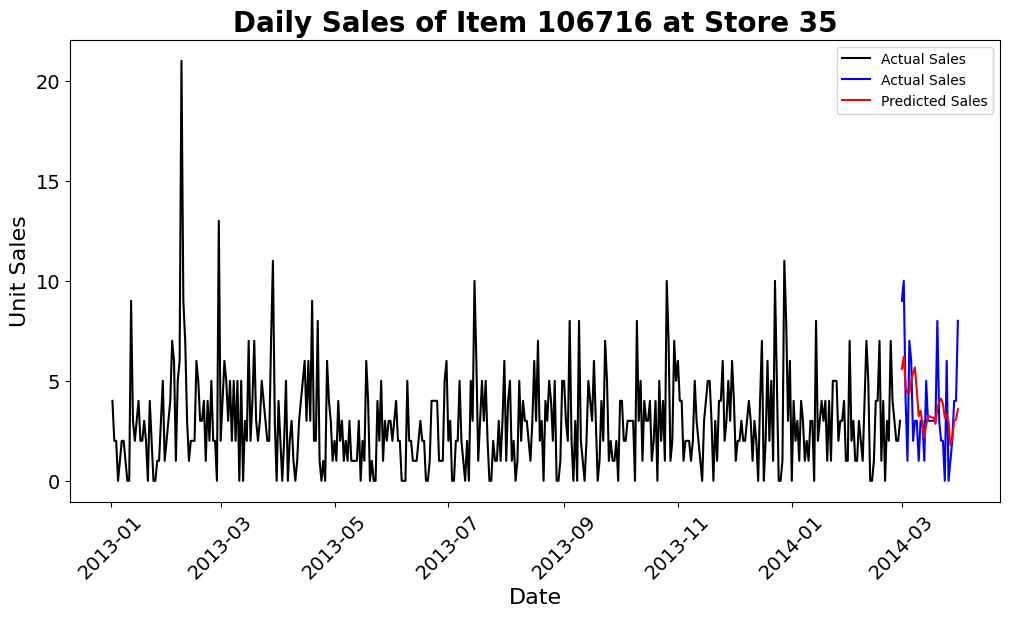

Metrics for Item 106716 and Store 35:
Bias: 0.05033583410324589
RMAD: 1.772321512622218
RMSE: 2.227413621300935


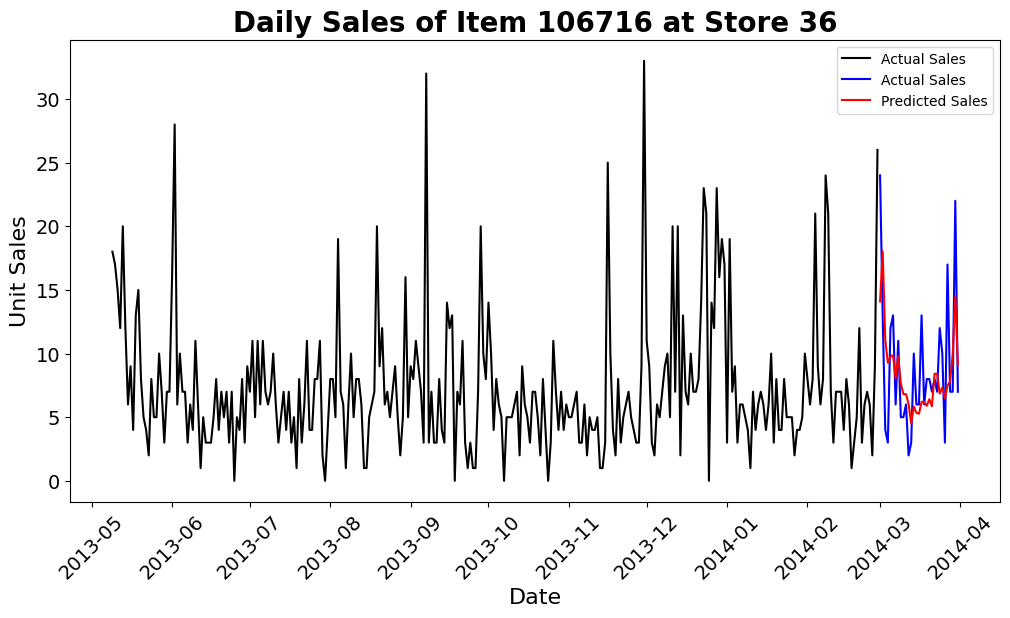

Metrics for Item 106716 and Store 36:
Bias: -0.5110249211711269
RMAD: 3.261247096523162
RMSE: 4.189615578103005


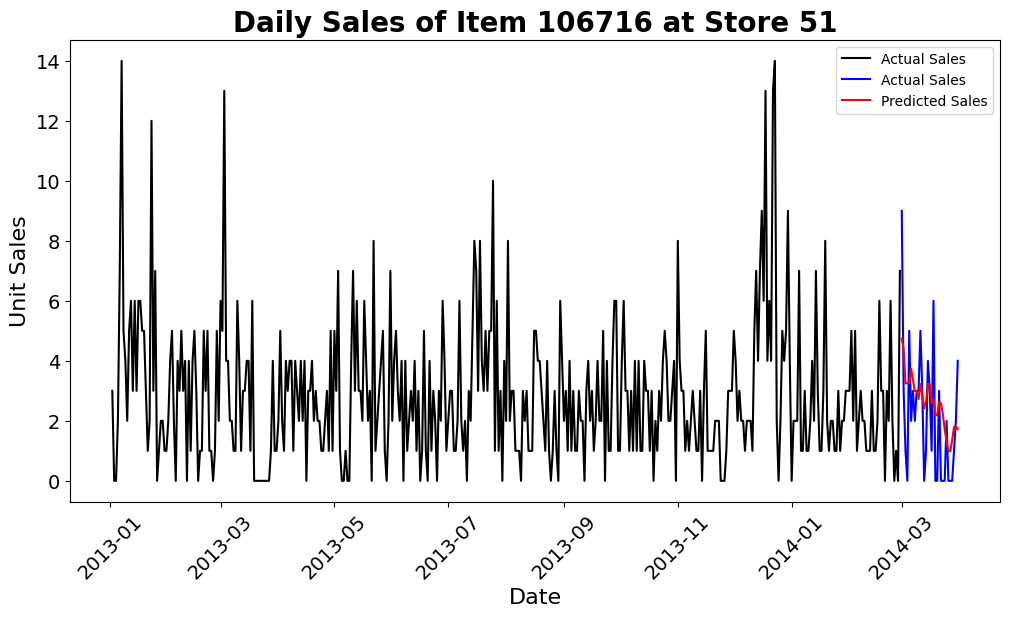

Metrics for Item 106716 and Store 51:
Bias: 0.4872093892866565
RMAD: 1.5047479906389791
RMSE: 1.8211755983668991


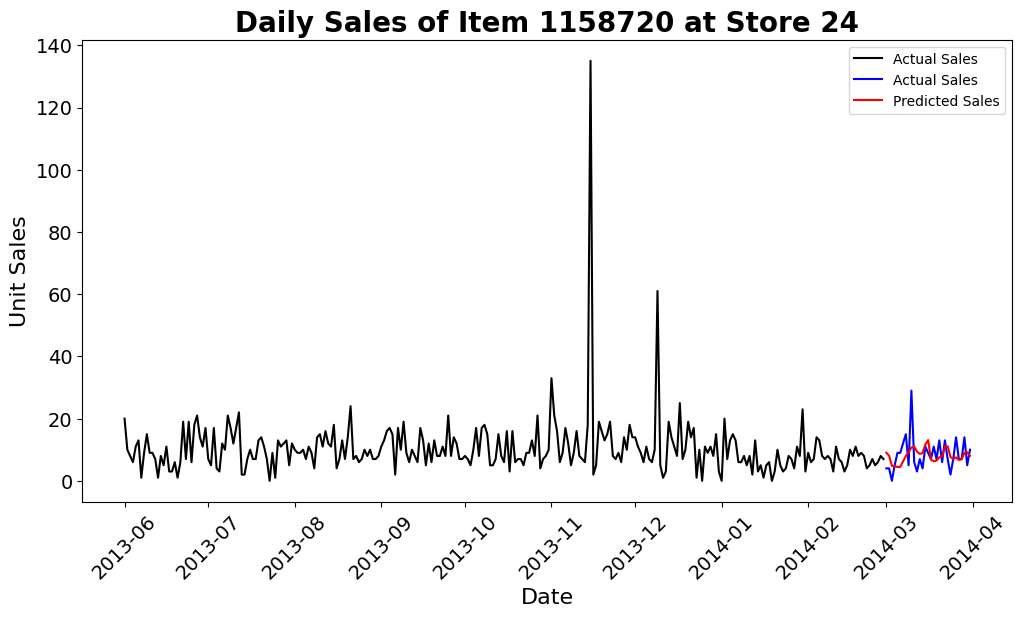

Metrics for Item 1158720 and Store 24:
Bias: -0.3320561224414456
RMAD: 3.9956769174145115
RMSE: 5.231940005481733


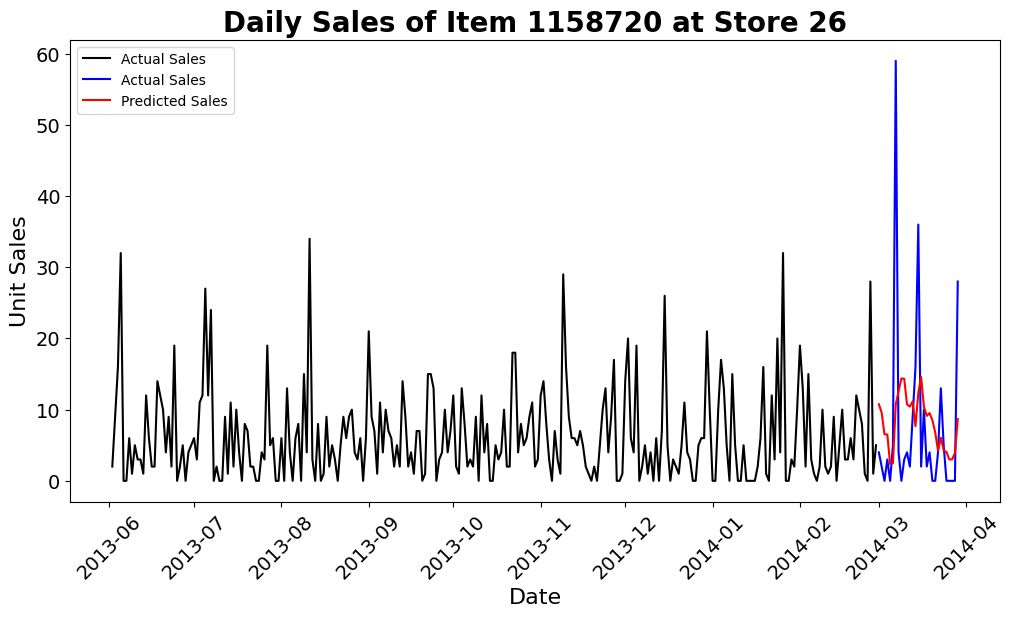

Metrics for Item 1158720 and Store 26:
Bias: 0.8217420989069445
RMAD: 8.38695867308255
RMSE: 12.441614058020122


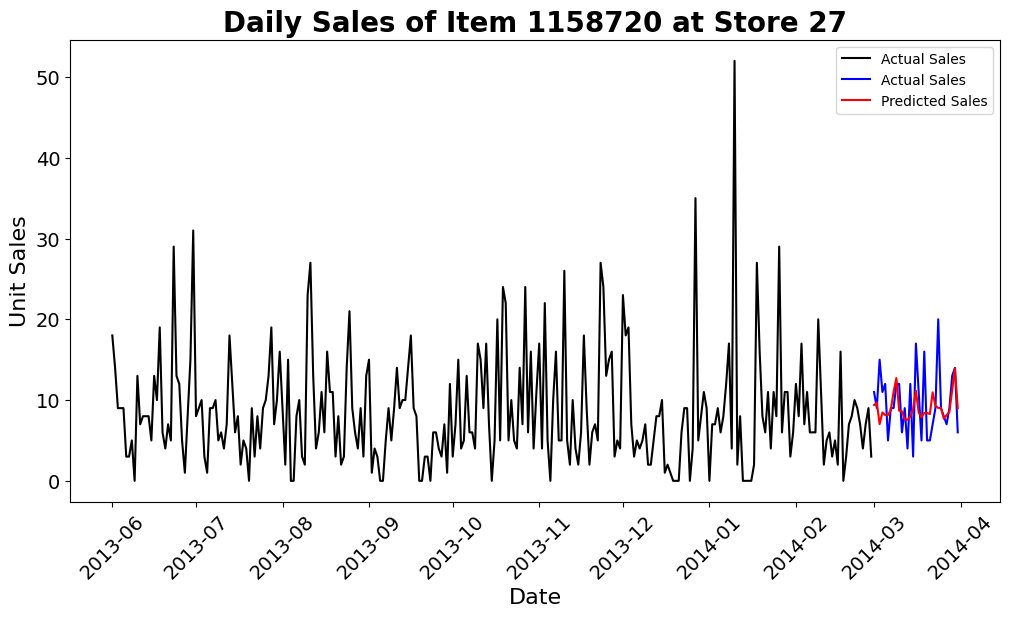

Metrics for Item 1158720 and Store 27:
Bias: -0.5831253913141066
RMAD: 2.940347456162976
RMSE: 3.872627250492511


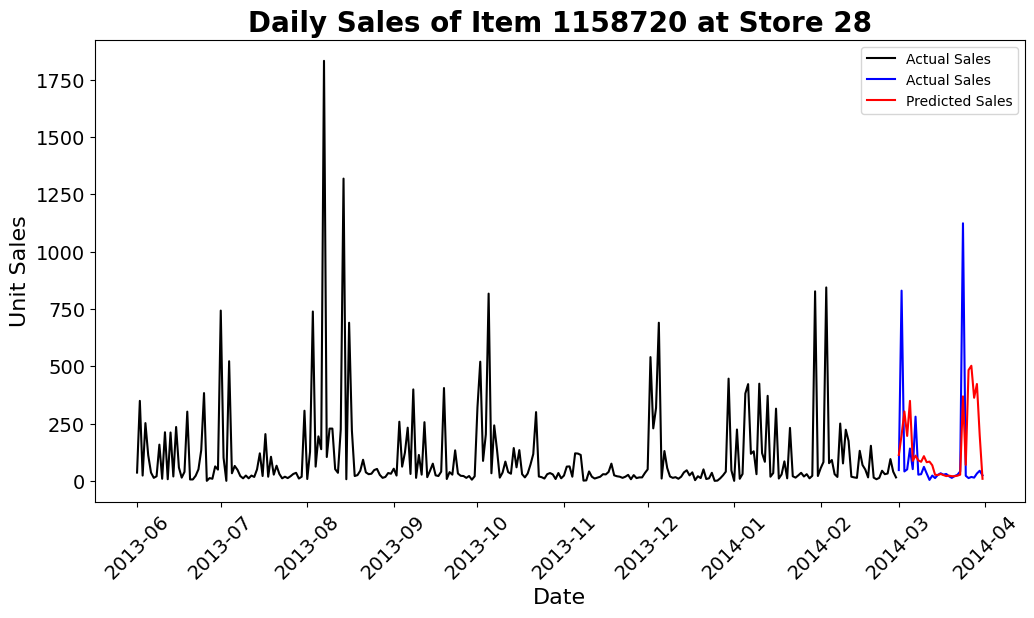

Metrics for Item 1158720 and Store 28:
Bias: 44.26152807666409
RMAD: 147.76638147907872
RMSE: 248.4708711882978


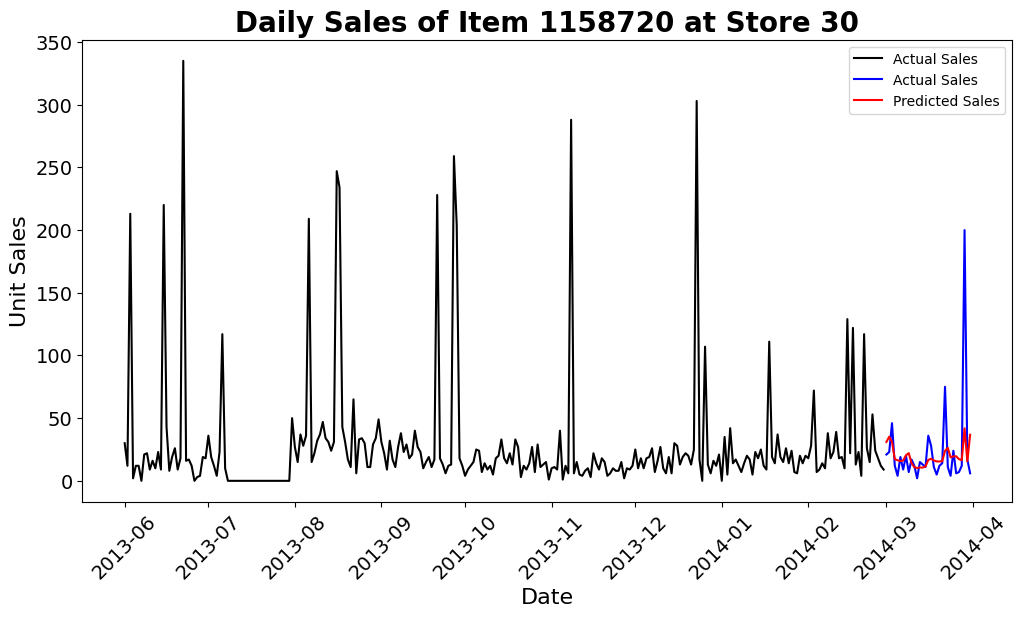

Metrics for Item 1158720 and Store 30:
Bias: -2.984102956710323
RMAD: 14.666882638008364
RMSE: 31.632921016422614


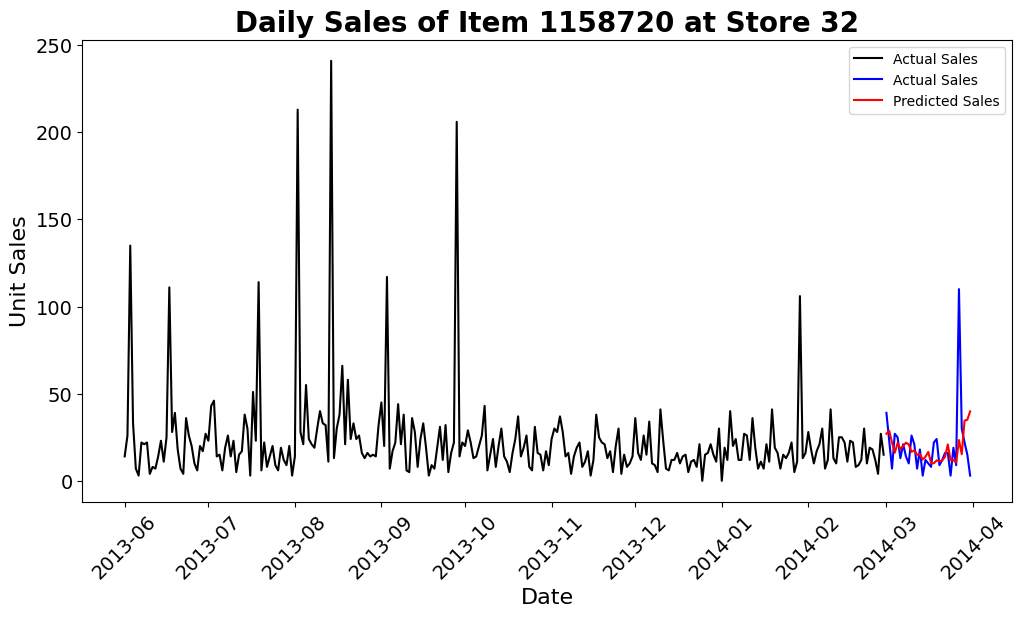

Metrics for Item 1158720 and Store 32:
Bias: -0.5957112158498457
RMAD: 10.876693448712748
RMSE: 18.957077334760378


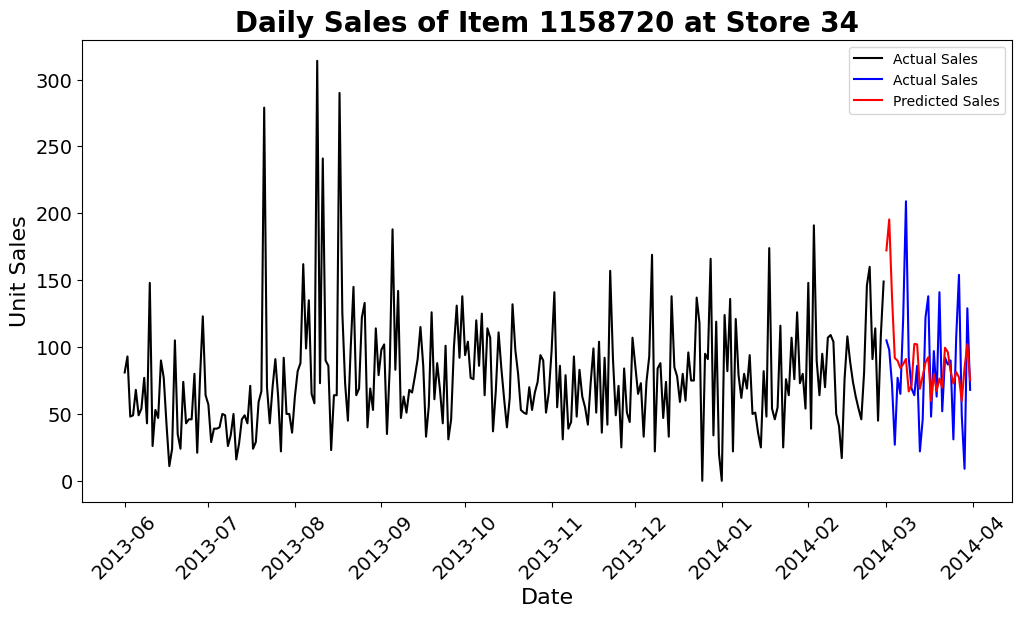

Metrics for Item 1158720 and Store 34:
Bias: 5.619279184649067
RMAD: 36.26156788487588
RMSE: 46.45915082250851


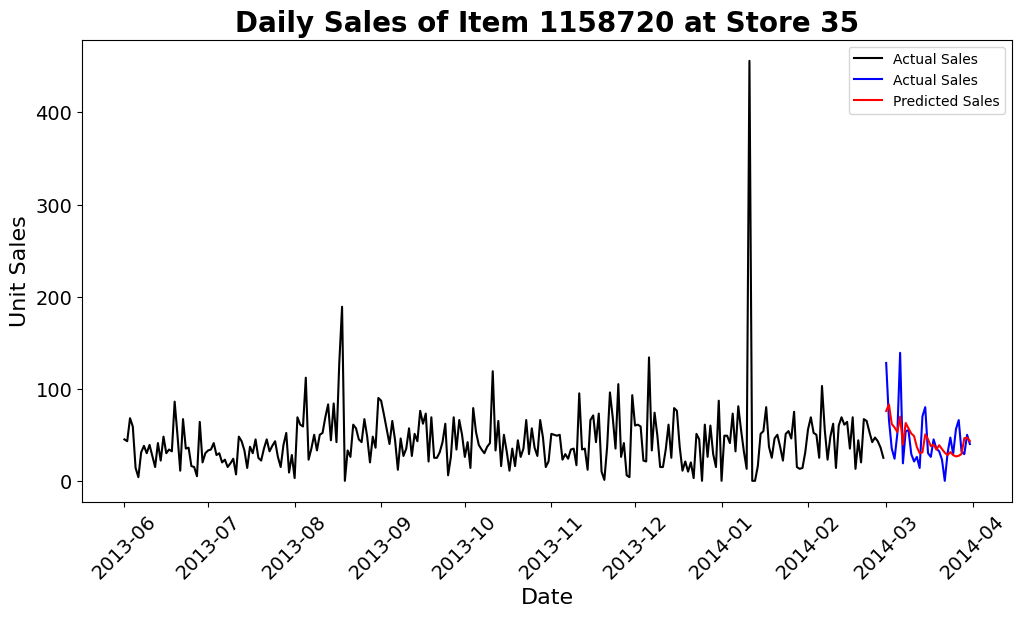

Metrics for Item 1158720 and Store 35:
Bias: -0.22194443979570944
RMAD: 18.512260867703347
RMSE: 24.55885373914514


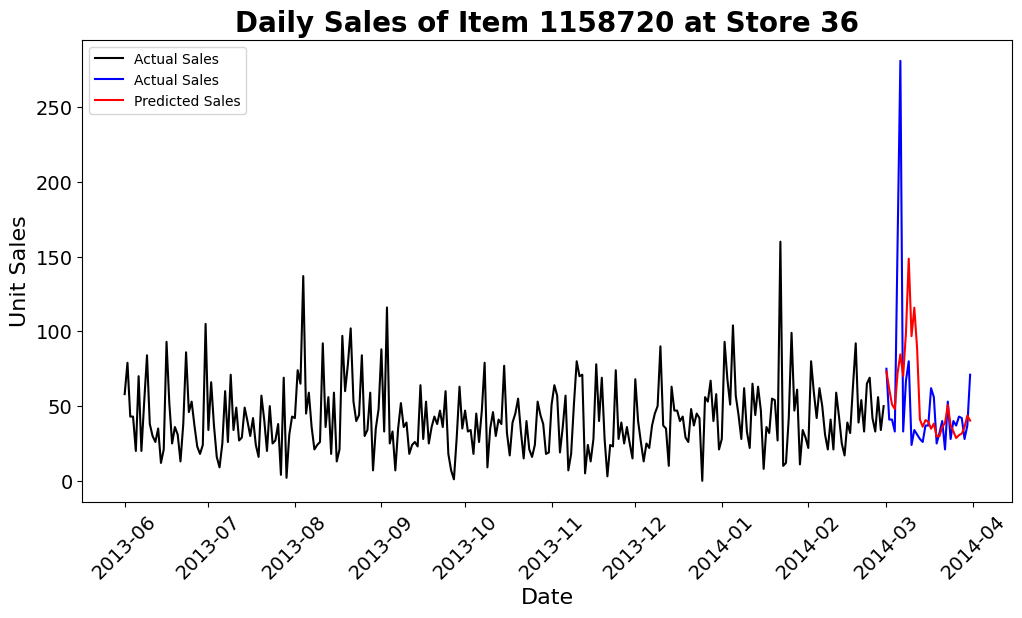

Metrics for Item 1158720 and Store 36:
Bias: 2.077551995554278
RMAD: 28.33155828906644
RMSE: 48.35553751953269


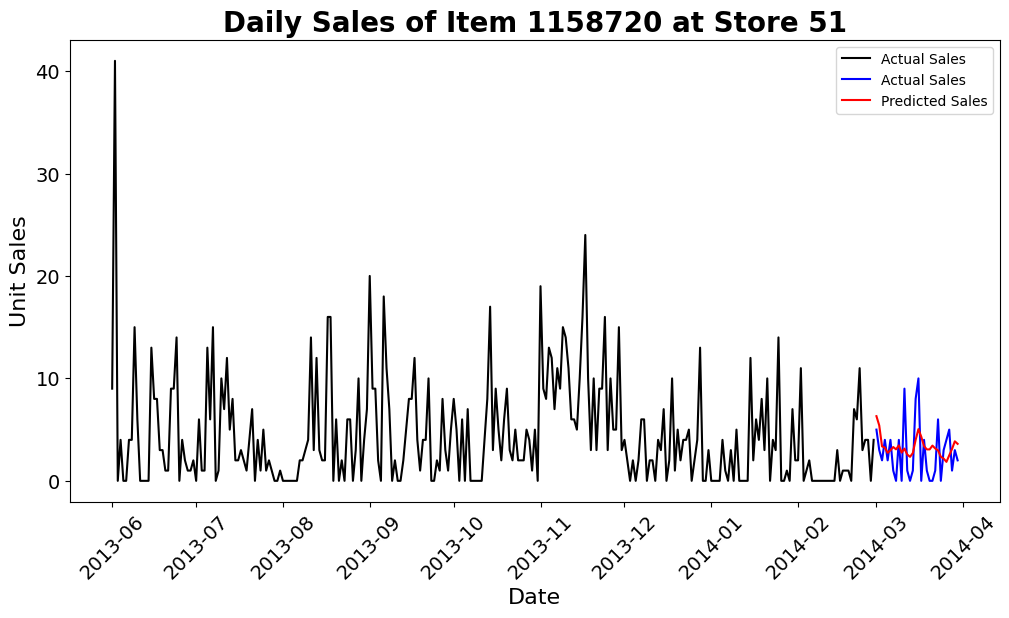

Metrics for Item 1158720 and Store 51:
Bias: 0.5103901505470276
RMAD: 2.2600118041038515
RMSE: 2.6018793041783934


In [47]:
# Calculate metrics values and Plot the actual vs predicted values
rmad_values = []
bias_values = []
rmse_values = []
plot_paths = []
plot_count  = 0
for (item_nbr, store_nbr), group in df_filled.groupby(['item_nbr', 'store_nbr']):
  #group = group.groupby(['date']).sum()['unit_sales'].reset_index()
  test_series = group[group['date'] >= split_date]
  if(len(test_series)>10):
    X_test = test_series.drop('unit_sales', axis=1)
    X_test = X_test.drop('date', axis=1)
    y_test = test_series['unit_sales']
    # Make predictions on the test set
    y_pred = xgboost_model.predict(X_test)

    if plot_count<20:
      train_series = group[group['date'] < split_date]
      plt.figure(figsize=(12, 6))
      plt.plot(train_series['date'], train_series['unit_sales'].values, label='Actual Sales', color='black')
      plt.plot(test_series['date'], y_test.values, label='Actual Sales', color='blue')
      plt.plot(test_series['date'], y_pred, label='Predicted Sales', color='red')
      plt.title(f'Daily Sales of Item {item_nbr} at Store {store_nbr}', fontsize=20, fontweight='bold')
      plt.xlabel('Date', fontsize=16)
      plt.ylabel('Unit Sales', fontsize=16)
      plt.xticks(fontsize=14, rotation=45)
      plt.yticks(fontsize=14)
      file_path = f'XGBoost_forecast_store_{store_nbr}_item_{item_nbr}.png'
      plt.legend()
      plt.savefig(file_path)  # Saves the plot as a PNG file
      plt.show()
      plot_paths.append(file_path)
      plot_count = plot_count + 1

    #Calculate metric values for XGBoost model
    # Bias calculation: mean of the residuals (y_pred - y_test)
    bias = np.mean(y_pred - y_test)
    bias_values.append(bias)
    # Root Mean Absolute Deviation (RMAD)
    rmad = np.mean(np.abs(y_pred - y_test))
    rmad_values.append(rmad)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

    #print mitrics
    print(f"Metrics for Item {item_nbr} and Store {store_nbr}:")
    print(f"Bias: {bias}")
    print(f"RMAD: {rmad}")
    print(f"RMSE: {rmse}")


## Log metrics for XGBoost model in MLFlow

In [48]:
import mlflow.xgboost
with mlflow.start_run(run_name="XGBoost_store_item_features_run"):
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")
    mlflow.log_param("objective", "reg:squarederror") #value we used above
    mlflow.log_param("n_estimators", 100) #value we used above
    mlflow.log_param("max_depth", 5) #value we used above
    mlflow.log_param("learning_rate", 0.1) #value we used above
    mlflow.log_metric("rMAD", sum(rmad_values)/len(rmad_values)) #average rMAD
    mlflow.log_metric("Bias", sum(bias_values)/len(bias_values)) #average Bias
    mlflow.log_metric("RMSE", sum(rmse_values)/len(rmse_values)) #average RMSE
    for plot_path in plot_paths:
      mlflow.log_artifact(plot_path, artifact_path="plots")
    # Log the XGBoost model
    ## Example data (replace with a sample from your dataset)
    #input_example = X_train[:5]
    # Infer signature from input and output data
    signature = infer_signature(X_train, xgboost_model.predict(X_train))
    #print(signature)
    #mlflow.sklearn.log_model(xgboost_model, "xgboost_model",
    #                         signature=signature)
    mlflow.xgboost.log_model(xgboost_model, "xgboost_model",
                             signature=signature)
    # Optionally log parameters, metrics, etc.
    mlflow.log_params(xgboost_model.get_params())
    mlflow.log_metric("train_score", xgboost_model.score(X_train, y_train))

Run ID: 1d95e5ef6b3f4840b8423507c3d93f42


/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:27:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose bet

In [49]:
#After greedSearch new hyperparameters Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, max_depth=3, learning_rate=0.1, enable_categorical=True)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

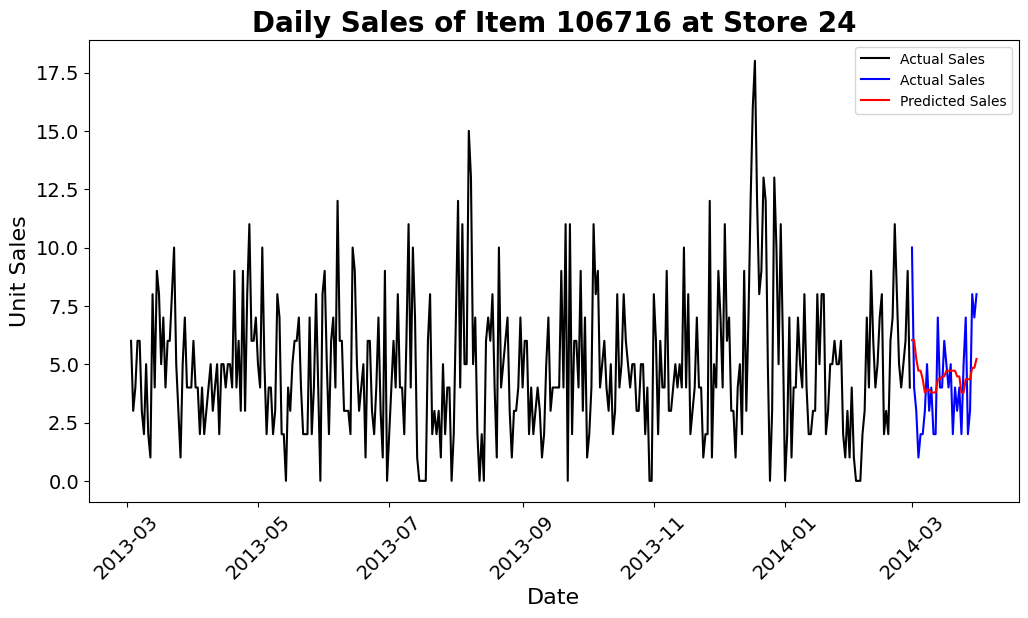

Metrics for Item 106716 and Store 24:
Bias: 0.28314212060743765
RMAD: 1.7002297524482972
RMSE: 1.989651931709714


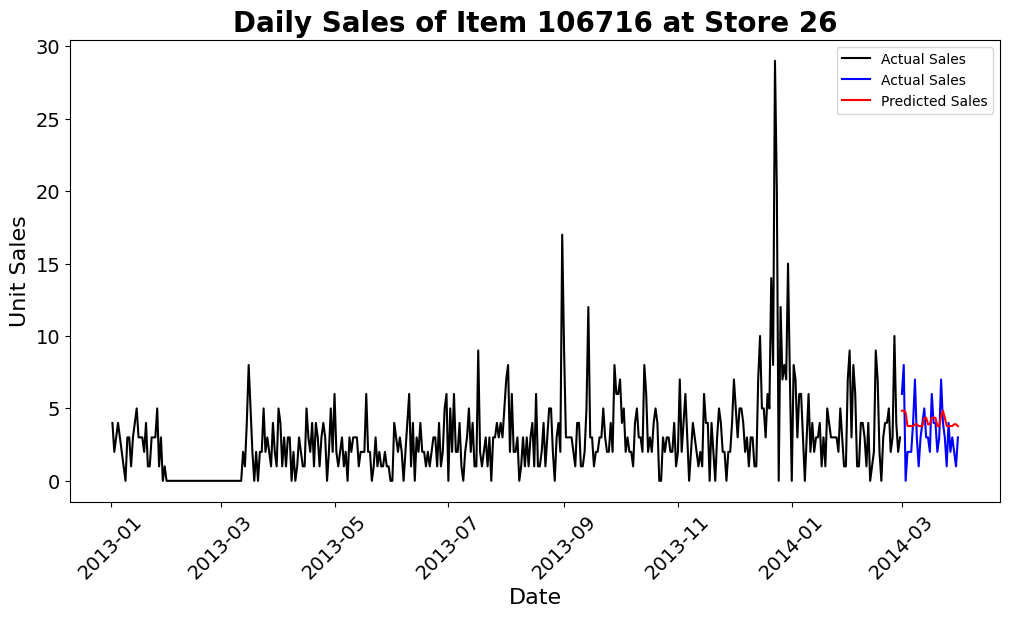

Metrics for Item 106716 and Store 26:
Bias: 0.7182483980732579
RMAD: 1.548704654939713
RMSE: 1.8722876926046135


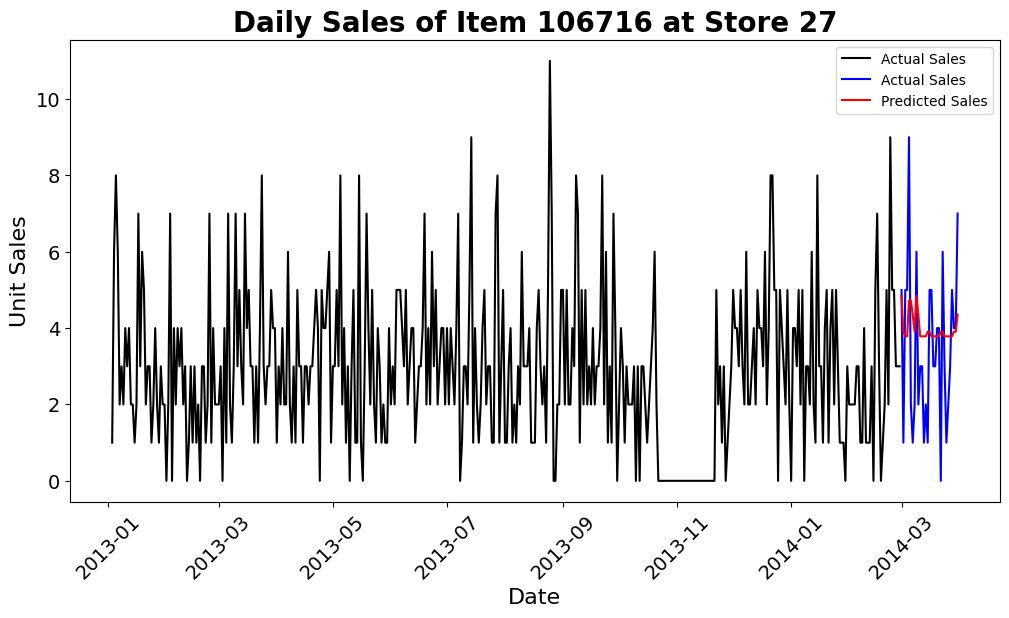

Metrics for Item 106716 and Store 27:
Bias: 0.5479025225485524
RMAD: 1.6389713441171954
RMSE: 1.9985724807681435


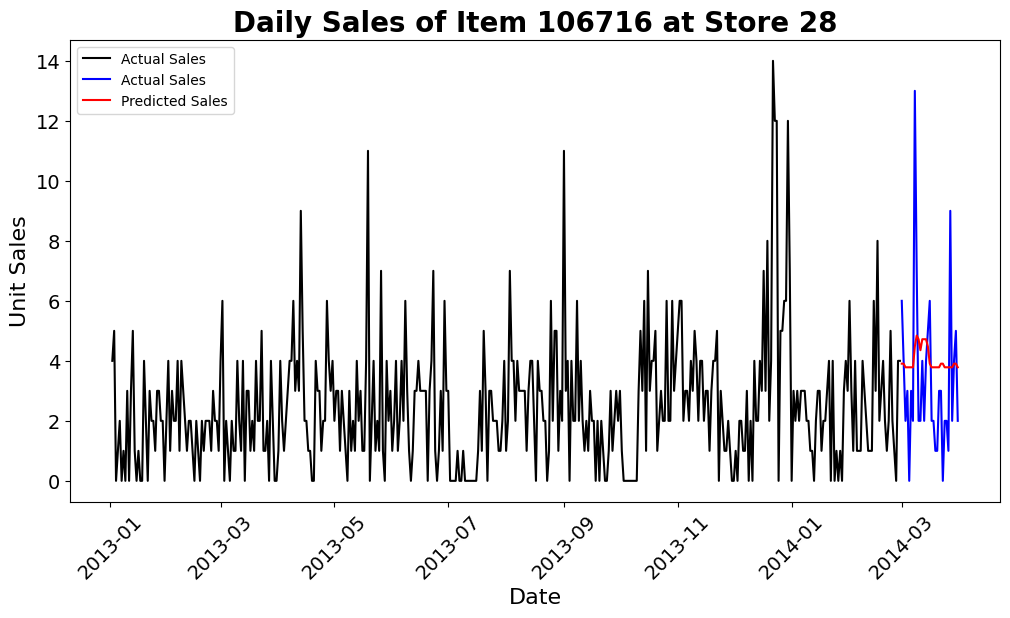

Metrics for Item 106716 and Store 28:
Bias: 0.6748694527533746
RMAD: 2.0872507018427693
RMSE: 2.6465510032247974


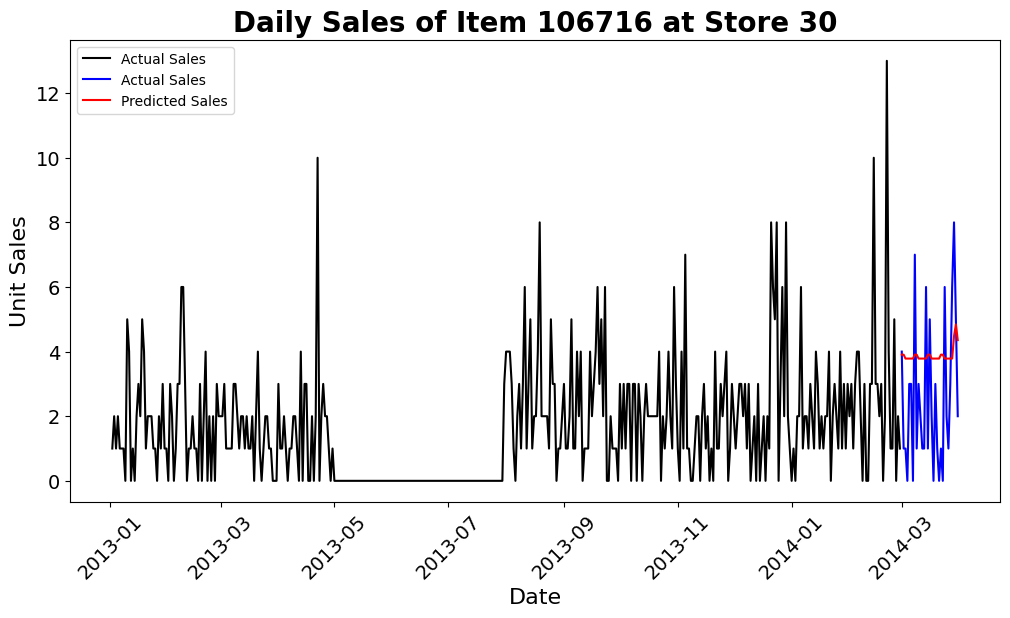

Metrics for Item 106716 and Store 30:
Bias: 1.3421572254550072
RMAD: 2.284813665574597
RMSE: 2.5476283845102836


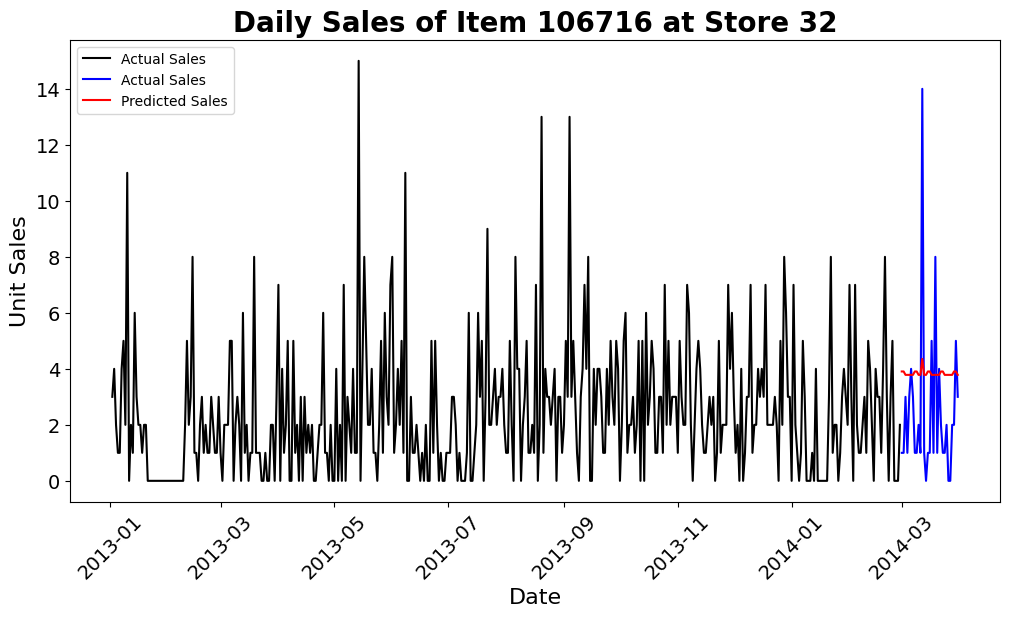

Metrics for Item 106716 and Store 32:
Bias: 1.4226038225235478
RMAD: 2.4937109639567714
RMSE: 3.013103023385965


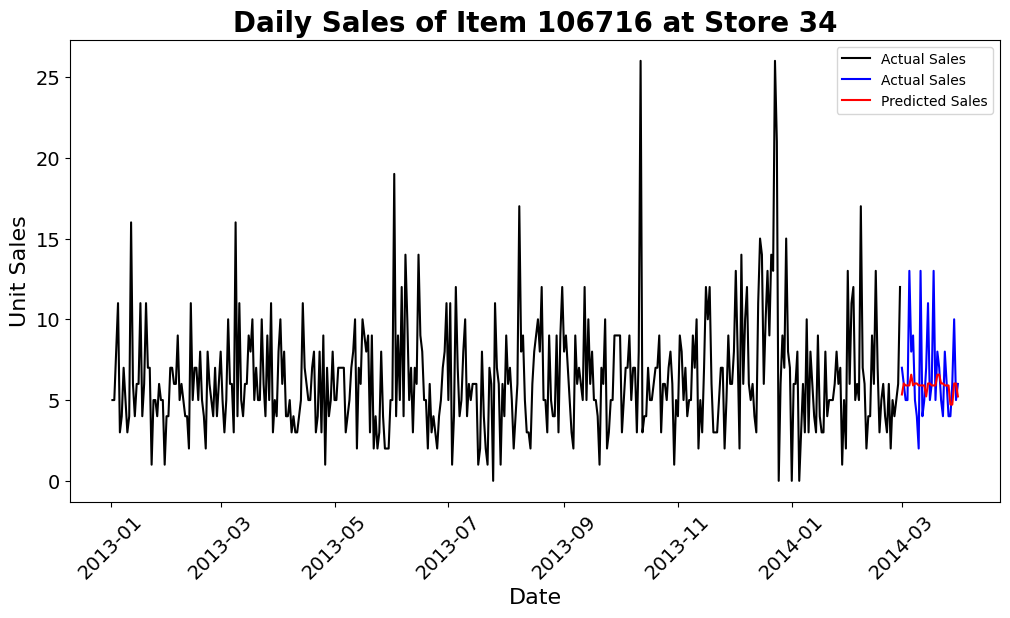

Metrics for Item 106716 and Store 34:
Bias: -0.7781949966184555
RMAD: 2.084616030416181
RMSE: 2.877195537093266


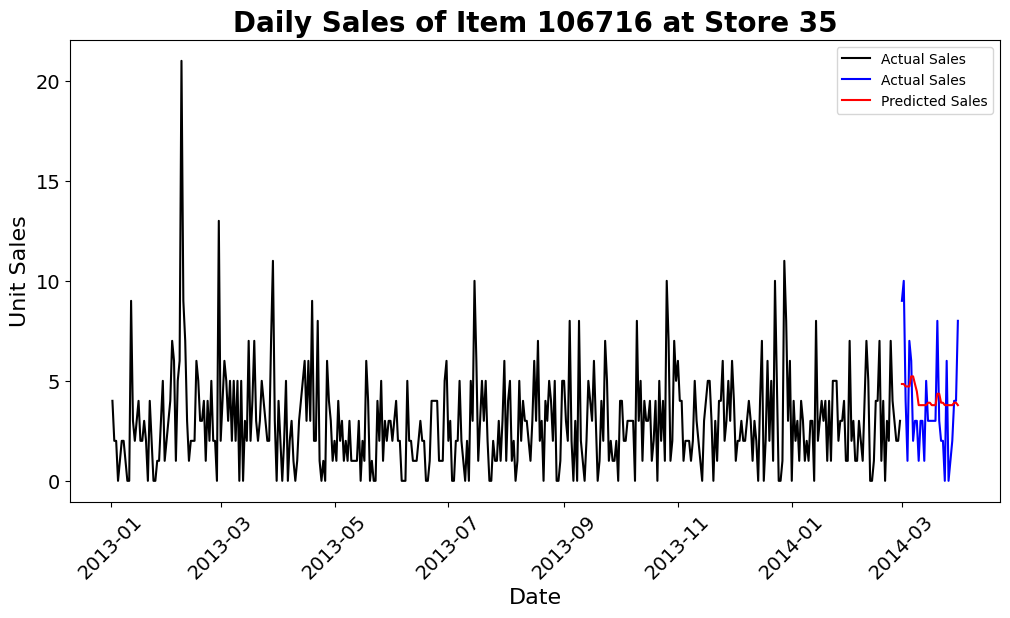

Metrics for Item 106716 and Store 35:
Bias: 0.5076047528174615
RMAD: 2.0464887619018555
RMSE: 2.4520321633446582


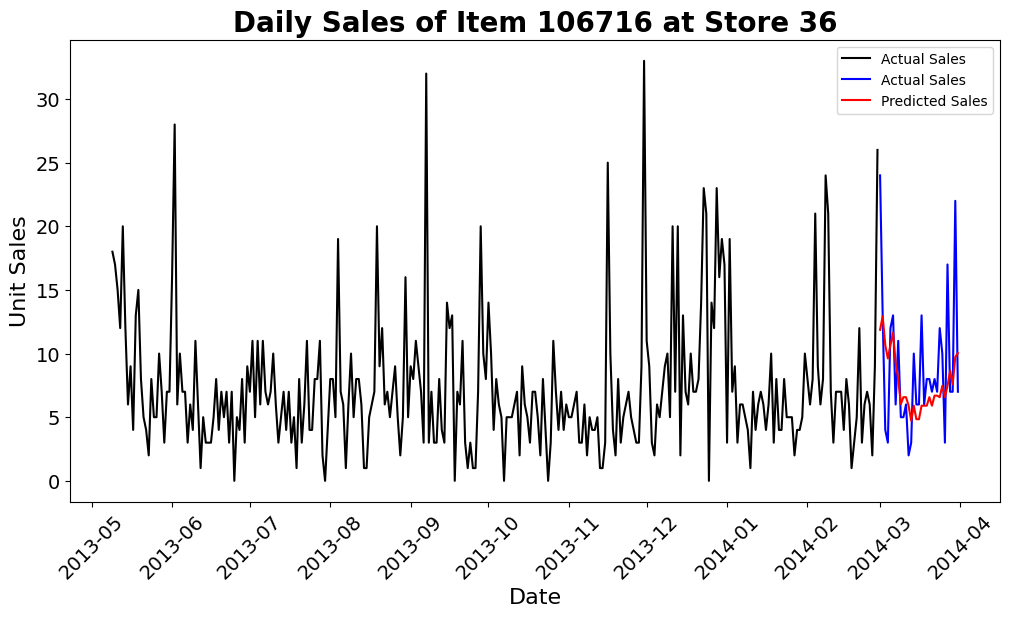

Metrics for Item 106716 and Store 36:
Bias: -1.072232723236084
RMAD: 3.279646058236399
RMSE: 4.622127806494827


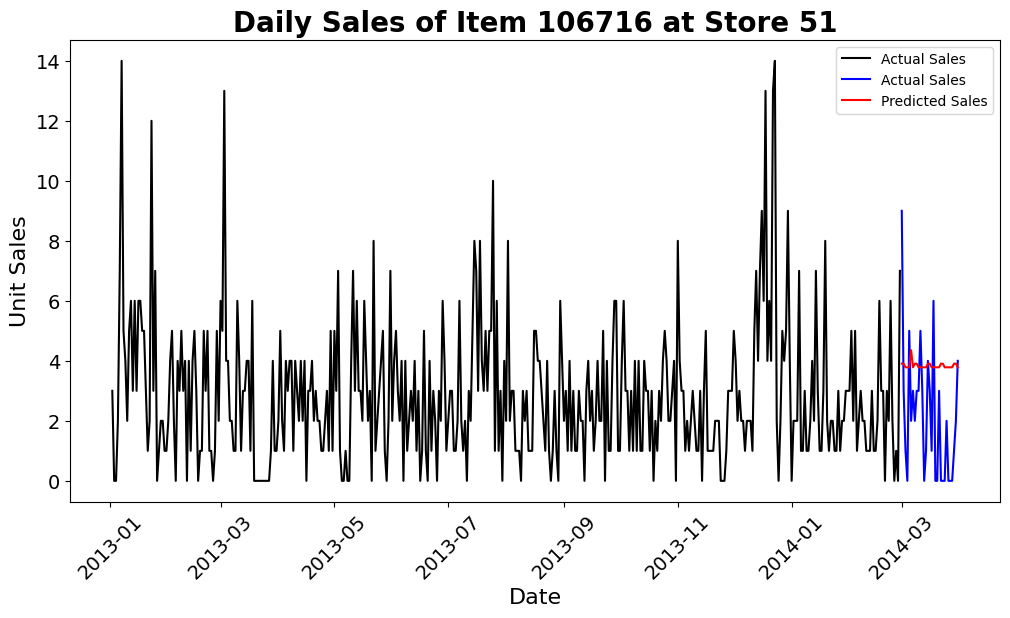

Metrics for Item 106716 and Store 51:
Bias: 1.712926403168709
RMAD: 2.361362641857516
RMSE: 2.733131880492697


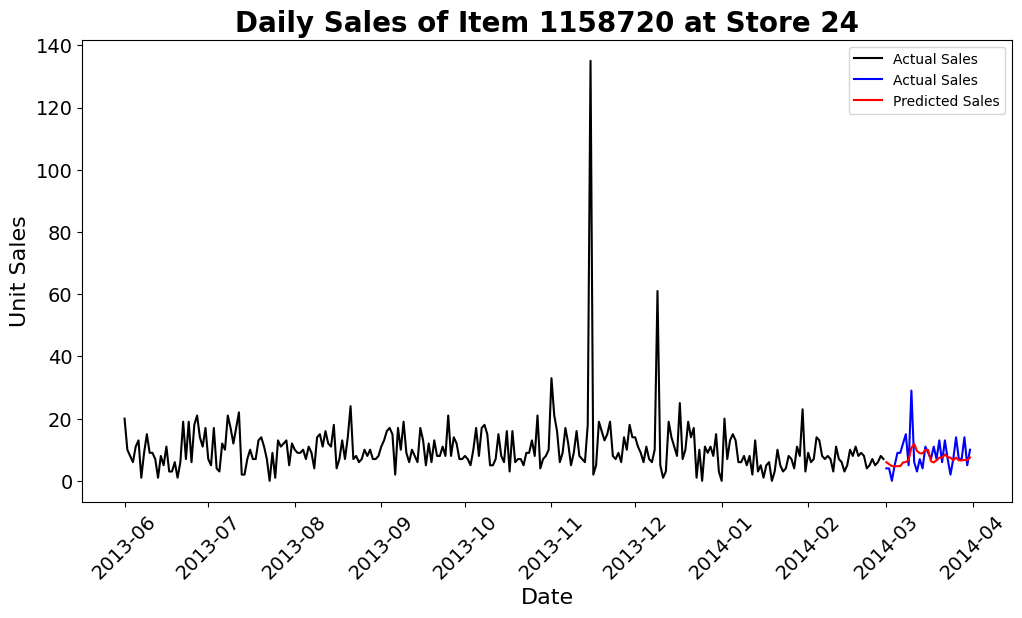

Metrics for Item 1158720 and Store 24:
Bias: -1.2297630156240156
RMAD: 3.751873923886207
RMSE: 5.218387252227247


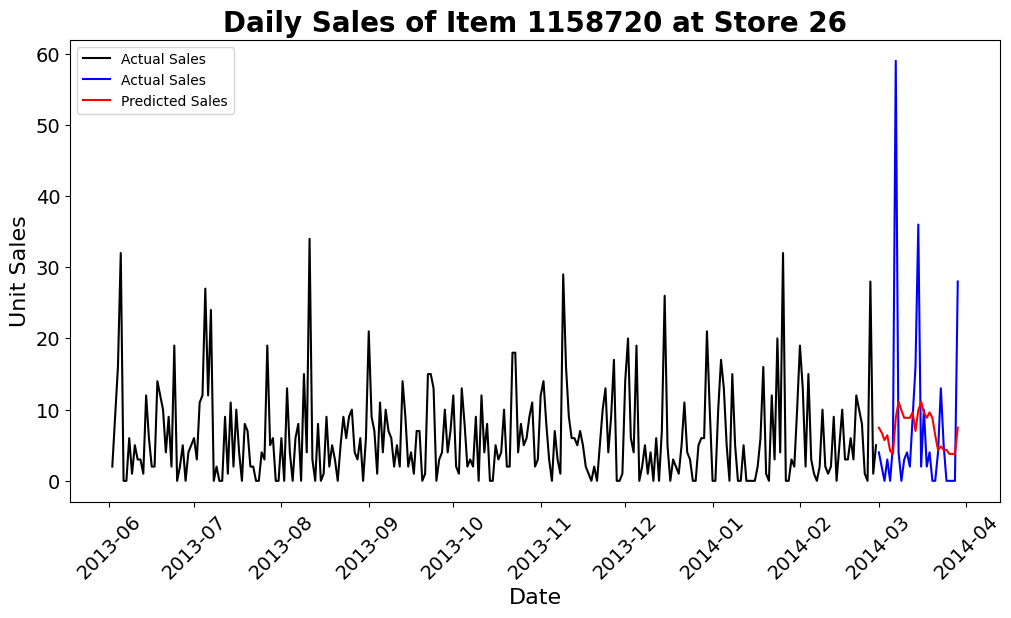

Metrics for Item 1158720 and Store 26:
Bias: -0.2259305427814352
RMAD: 7.785333370340282
RMSE: 12.401094645890998


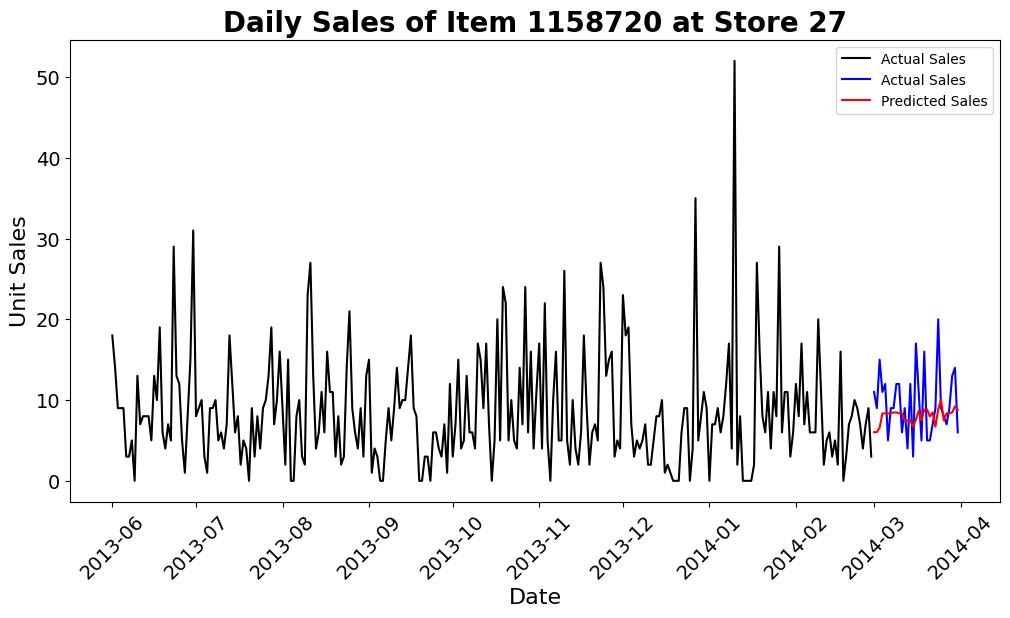

Metrics for Item 1158720 and Store 27:
Bias: -1.650418681483115
RMAD: 3.5068415980185232
RMSE: 4.318009492768029


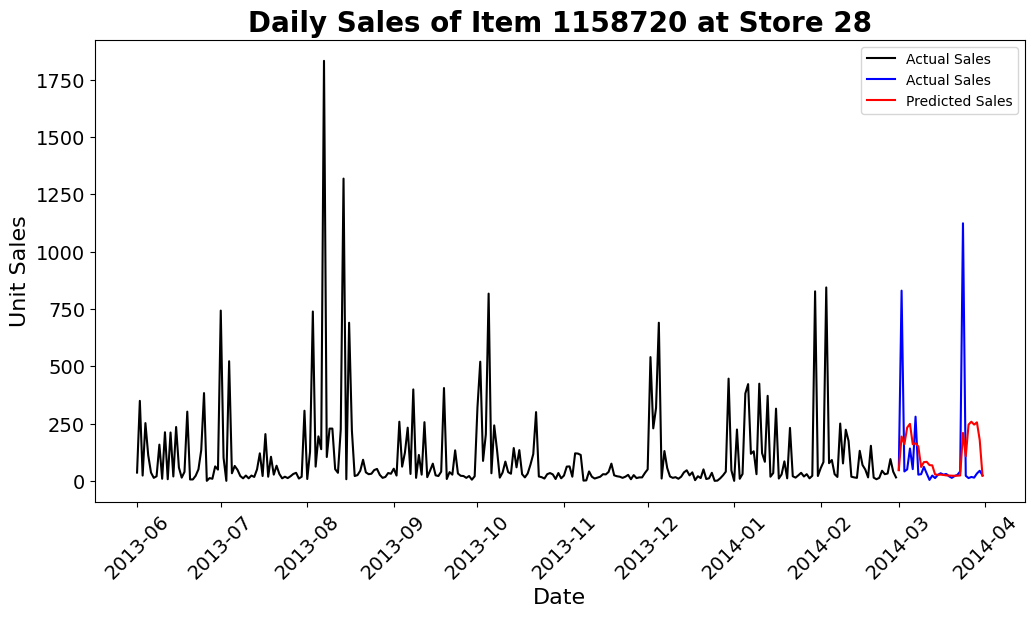

Metrics for Item 1158720 and Store 28:
Bias: 10.571393535983178
RMAD: 120.49231609221428
RMSE: 226.7280497773948


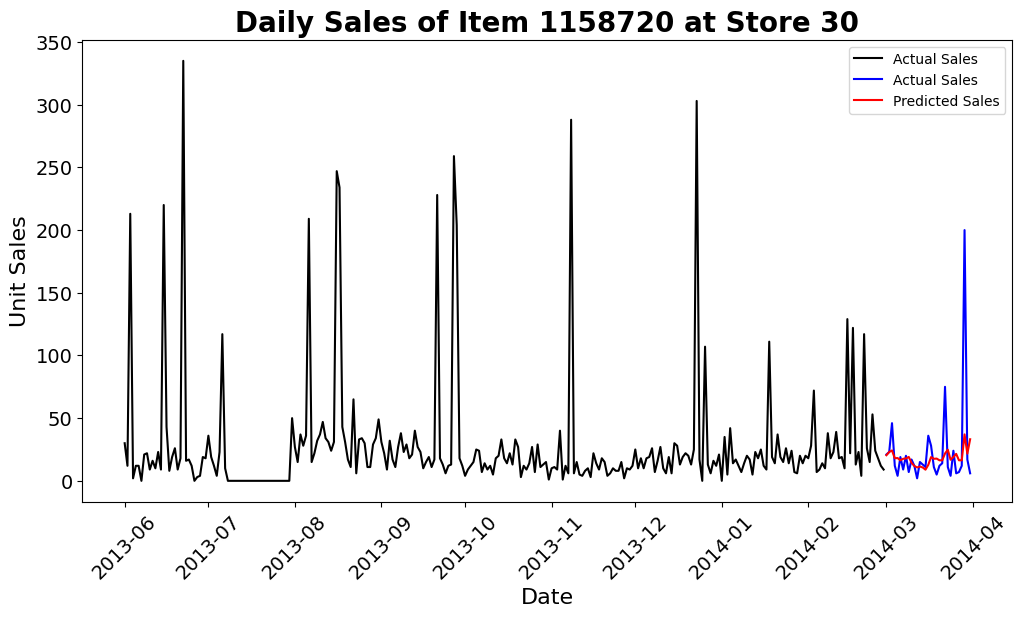

Metrics for Item 1158720 and Store 30:
Bias: -4.13044495736399
RMAD: 14.669694992803759
RMSE: 32.51124631569598


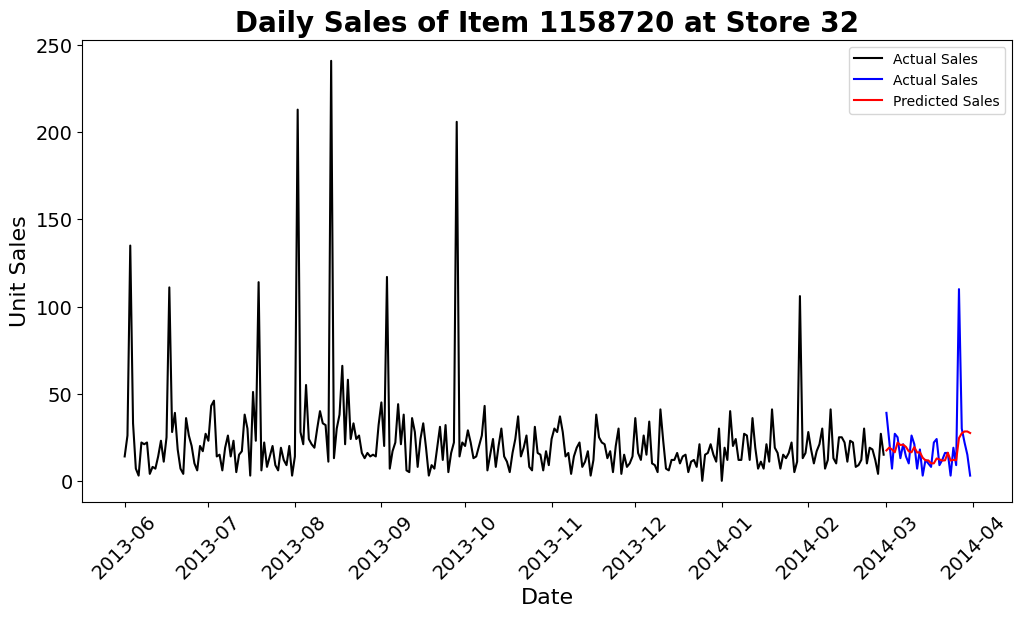

Metrics for Item 1158720 and Store 32:
Bias: -2.0038130360264934
RMAD: 9.3107728650493
RMSE: 17.697061039933168


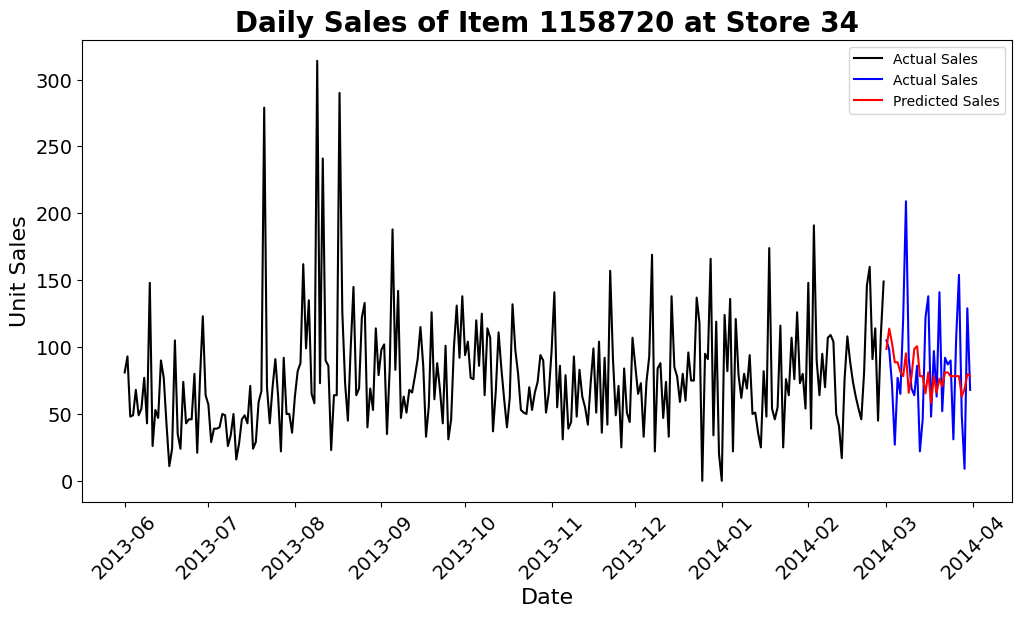

Metrics for Item 1158720 and Store 34:
Bias: -3.9064059103688886
RMAD: 32.73932093958701
RMSE: 41.505208548287435


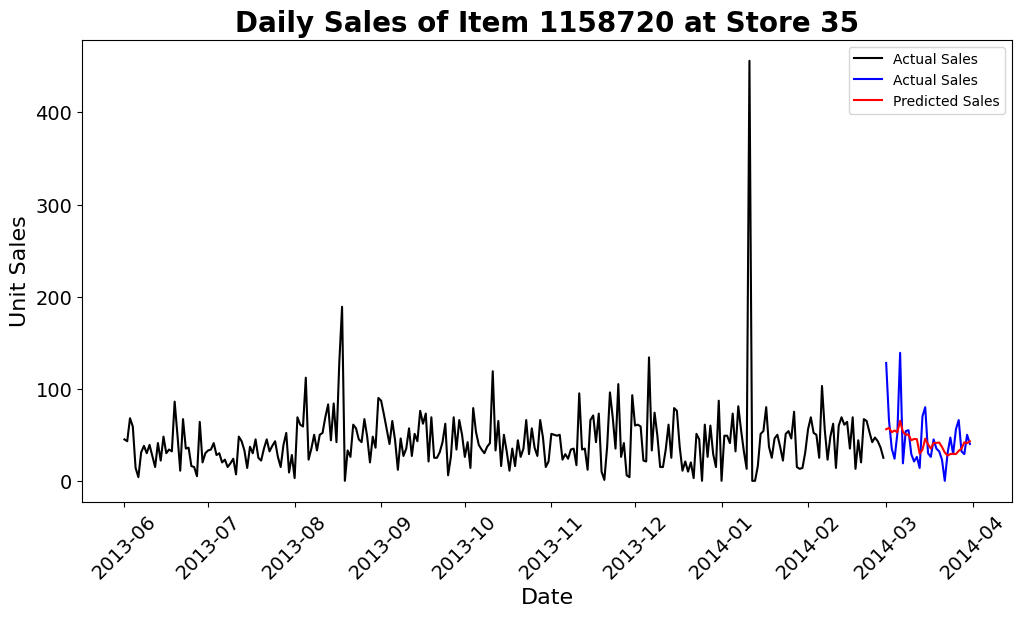

Metrics for Item 1158720 and Store 35:
Bias: -2.2743724084669545
RMAD: 18.842939007666804
RMSE: 26.006112148042437


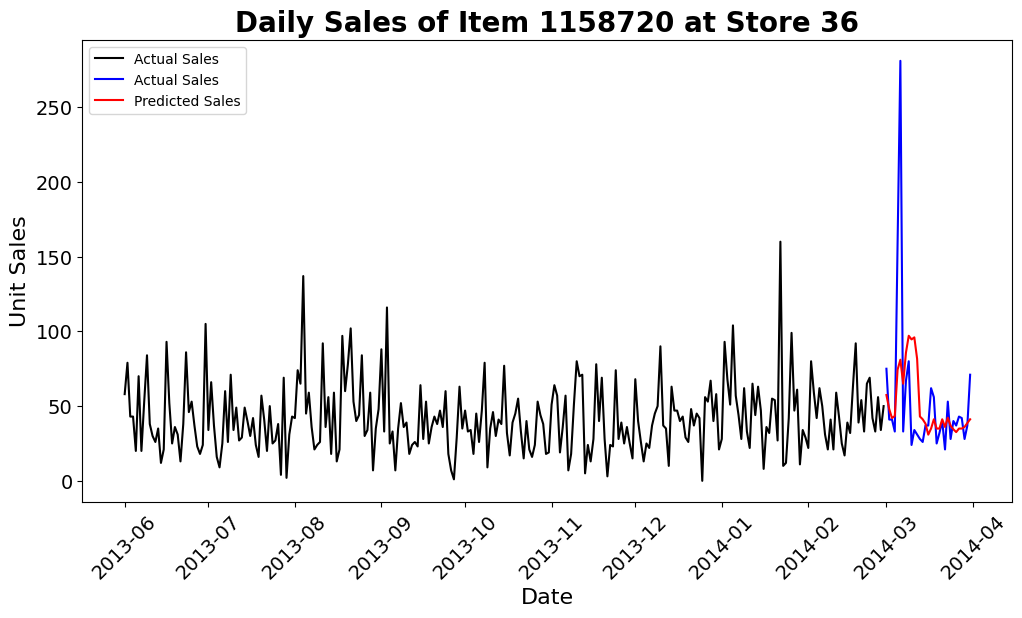

Metrics for Item 1158720 and Store 36:
Bias: -2.162158412318076
RMAD: 24.654992195867724
RMSE: 45.351490012269885


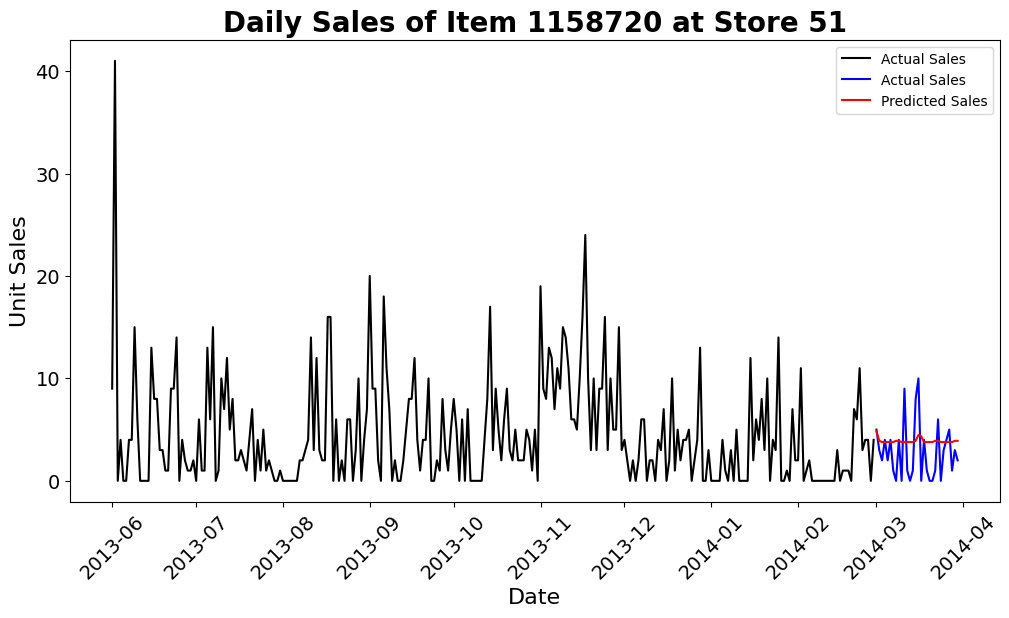

Metrics for Item 1158720 and Store 51:
Bias: 1.0940842469533285
RMAD: 2.3779599189758303
RMSE: 2.862688403096553


In [50]:
# Calculate metrics values and Plot the actual vs predicted values
rmad_values = []
bias_values = []
rmse_values = []
plot_paths = []
plot_count  = 0
for (item_nbr, store_nbr), group in df_filled.groupby(['item_nbr', 'store_nbr']):
  #group = group.groupby(['date']).sum()['unit_sales'].reset_index()
  test_series = group[group['date'] >= split_date]
  if(len(test_series)>10):
    X_test = test_series.drop('unit_sales', axis=1)
    X_test = X_test.drop('date', axis=1)
    y_test = test_series['unit_sales']
    # Make predictions on the test set
    y_pred = xgboost_model.predict(X_test)

    if plot_count<20:
      train_series = group[group['date'] < split_date]
      plt.figure(figsize=(12, 6))
      plt.plot(train_series['date'], train_series['unit_sales'].values, label='Actual Sales', color='black')
      plt.plot(test_series['date'], y_test.values, label='Actual Sales', color='blue')
      plt.plot(test_series['date'], y_pred, label='Predicted Sales', color='red')
      plt.title(f'Daily Sales of Item {item_nbr} at Store {store_nbr}', fontsize=20, fontweight='bold')
      plt.xlabel('Date', fontsize=16)
      plt.ylabel('Unit Sales', fontsize=16)
      plt.xticks(fontsize=14, rotation=45)
      plt.yticks(fontsize=14)
      file_path = f'XGBoost_forecast_store_{store_nbr}_item_{item_nbr}.png'
      plt.legend()
      plt.savefig(file_path)  # Saves the plot as a PNG file
      plt.show()
      plot_paths.append(file_path)
      plot_count = plot_count + 1

    #Calculate metric values for XGBoost model
    # Bias calculation: mean of the residuals (y_pred - y_test)
    bias = np.mean(y_pred - y_test)
    bias_values.append(bias)
    # Root Mean Absolute Deviation (RMAD)
    rmad = np.mean(np.abs(y_pred - y_test))
    rmad_values.append(rmad)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

    #print mitrics
    print(f"Metrics for Item {item_nbr} and Store {store_nbr}:")
    print(f"Bias: {bias}")
    print(f"RMAD: {rmad}")
    print(f"RMSE: {rmse}")


## Log metrics for XGBoost model in MLFlow

In [52]:
import mlflow.xgboost
with mlflow.start_run(run_name="XGBoost_store_item_features_run"):
    run_id = mlflow.active_run().info.run_id
    print(f"Run ID: {run_id}")
    mlflow.log_param("objective", "reg:squarederror") #value we used above
    mlflow.log_param("n_estimators", 50) #value we used above
    mlflow.log_param("max_depth", 3) #value we used above
    mlflow.log_param("learning_rate", 0.1) #value we used above
    mlflow.log_metric("rMAD", sum(rmad_values)/len(rmad_values)) #average rMAD
    mlflow.log_metric("Bias", sum(bias_values)/len(bias_values)) #average Bias
    mlflow.log_metric("RMSE", sum(rmse_values)/len(rmse_values)) #average RMSE
    for plot_path in plot_paths:
      mlflow.log_artifact(plot_path, artifact_path="plots")
    # Log the XGBoost model
    ## Example data (replace with a sample from your dataset)
    #input_example = X_train[:5]
    # Infer signature from input and output data
    signature = infer_signature(X_train, xgboost_model.predict(X_train))
    #print(signature)
    #mlflow.sklearn.log_model(xgboost_model, "xgboost_model",
    #                         signature=signature)
    mlflow.xgboost.log_model(xgboost_model, "xgboost_model",
                             signature=signature)
    # Optionally log parameters, metrics, etc.
    mlflow.log_params(xgboost_model.get_params())
    mlflow.log_metric("train_score", xgboost_model.score(X_train, y_train))

Run ID: 803893167c9b4a059f9a6e6a2e8f5503


/usr/local/lib/python3.11/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:31:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose bet

In [41]:
#GreedSearch for TimeSeriws XGboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state = 42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

rmad = np.mean(np.abs(y_pred - y_test))
bias = np.mean(y_pred - y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Bias: {bias}")
print(f"RMAD: {rmad}")
print(f"RMSE: {rmse}")


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Score: -31.621795809332053
Bias: 1.0940842469533285
RMAD: 2.3779599189758303
RMSE: 2.862688403096553


# (Optional) save Pickle file with the model in Google Drive
Next week we will create an application with our model. To serve model in the application, we create a pickle file below and next week we will use this file in our app.
Note: you will experiment a lot and create many models. Pickle file you need only for the best model you create this week. To learn more about pickle files, please check the additional material suggested for this week.

In [53]:
logged_model = 'runs:/803893167c9b4a059f9a6e6a2e8f5503/xgboost_model' # you can find run id of your best run in MLFlow UI. See the video in Sprint 4 for more detailed instruction

# Load model as a generic PyFuncModel.
#loaded_model = mlflow.pyfunc.load_model(logged_model)
#input_schema = loaded_model.metadata.get_input_schema()
#print(input_schema)

# Load model as xgboost model
loaded_model = mlflow.xgboost.load_model(logged_model)
print("=== Model type",type(loaded_model))

=== Model type <class 'xgboost.sklearn.XGBRegressor'>


In [54]:
# create the path to store pickle files of the models
!mkdir /content/drive/MyDrive/models/

mkdir: cannot create directory ‘/content/drive/MyDrive/models/’: File exists


In [57]:
import pickle
import joblib
# Save the model as a pickle file in Google Drive
pickle_path = '/content/drive/MyDrive/models/xgboost_model.pkl'  # Adjust Google Drive path as desired

with open(pickle_path, 'wb') as f:
    pickle.dump(loaded_model, f)
#Save the model as a pickle file in content

joblib.dump(loaded_model, pickle_path)
loaded_model = joblib.load(pickle_path)


print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /content/drive/MyDrive/models/xgboost_model.pkl


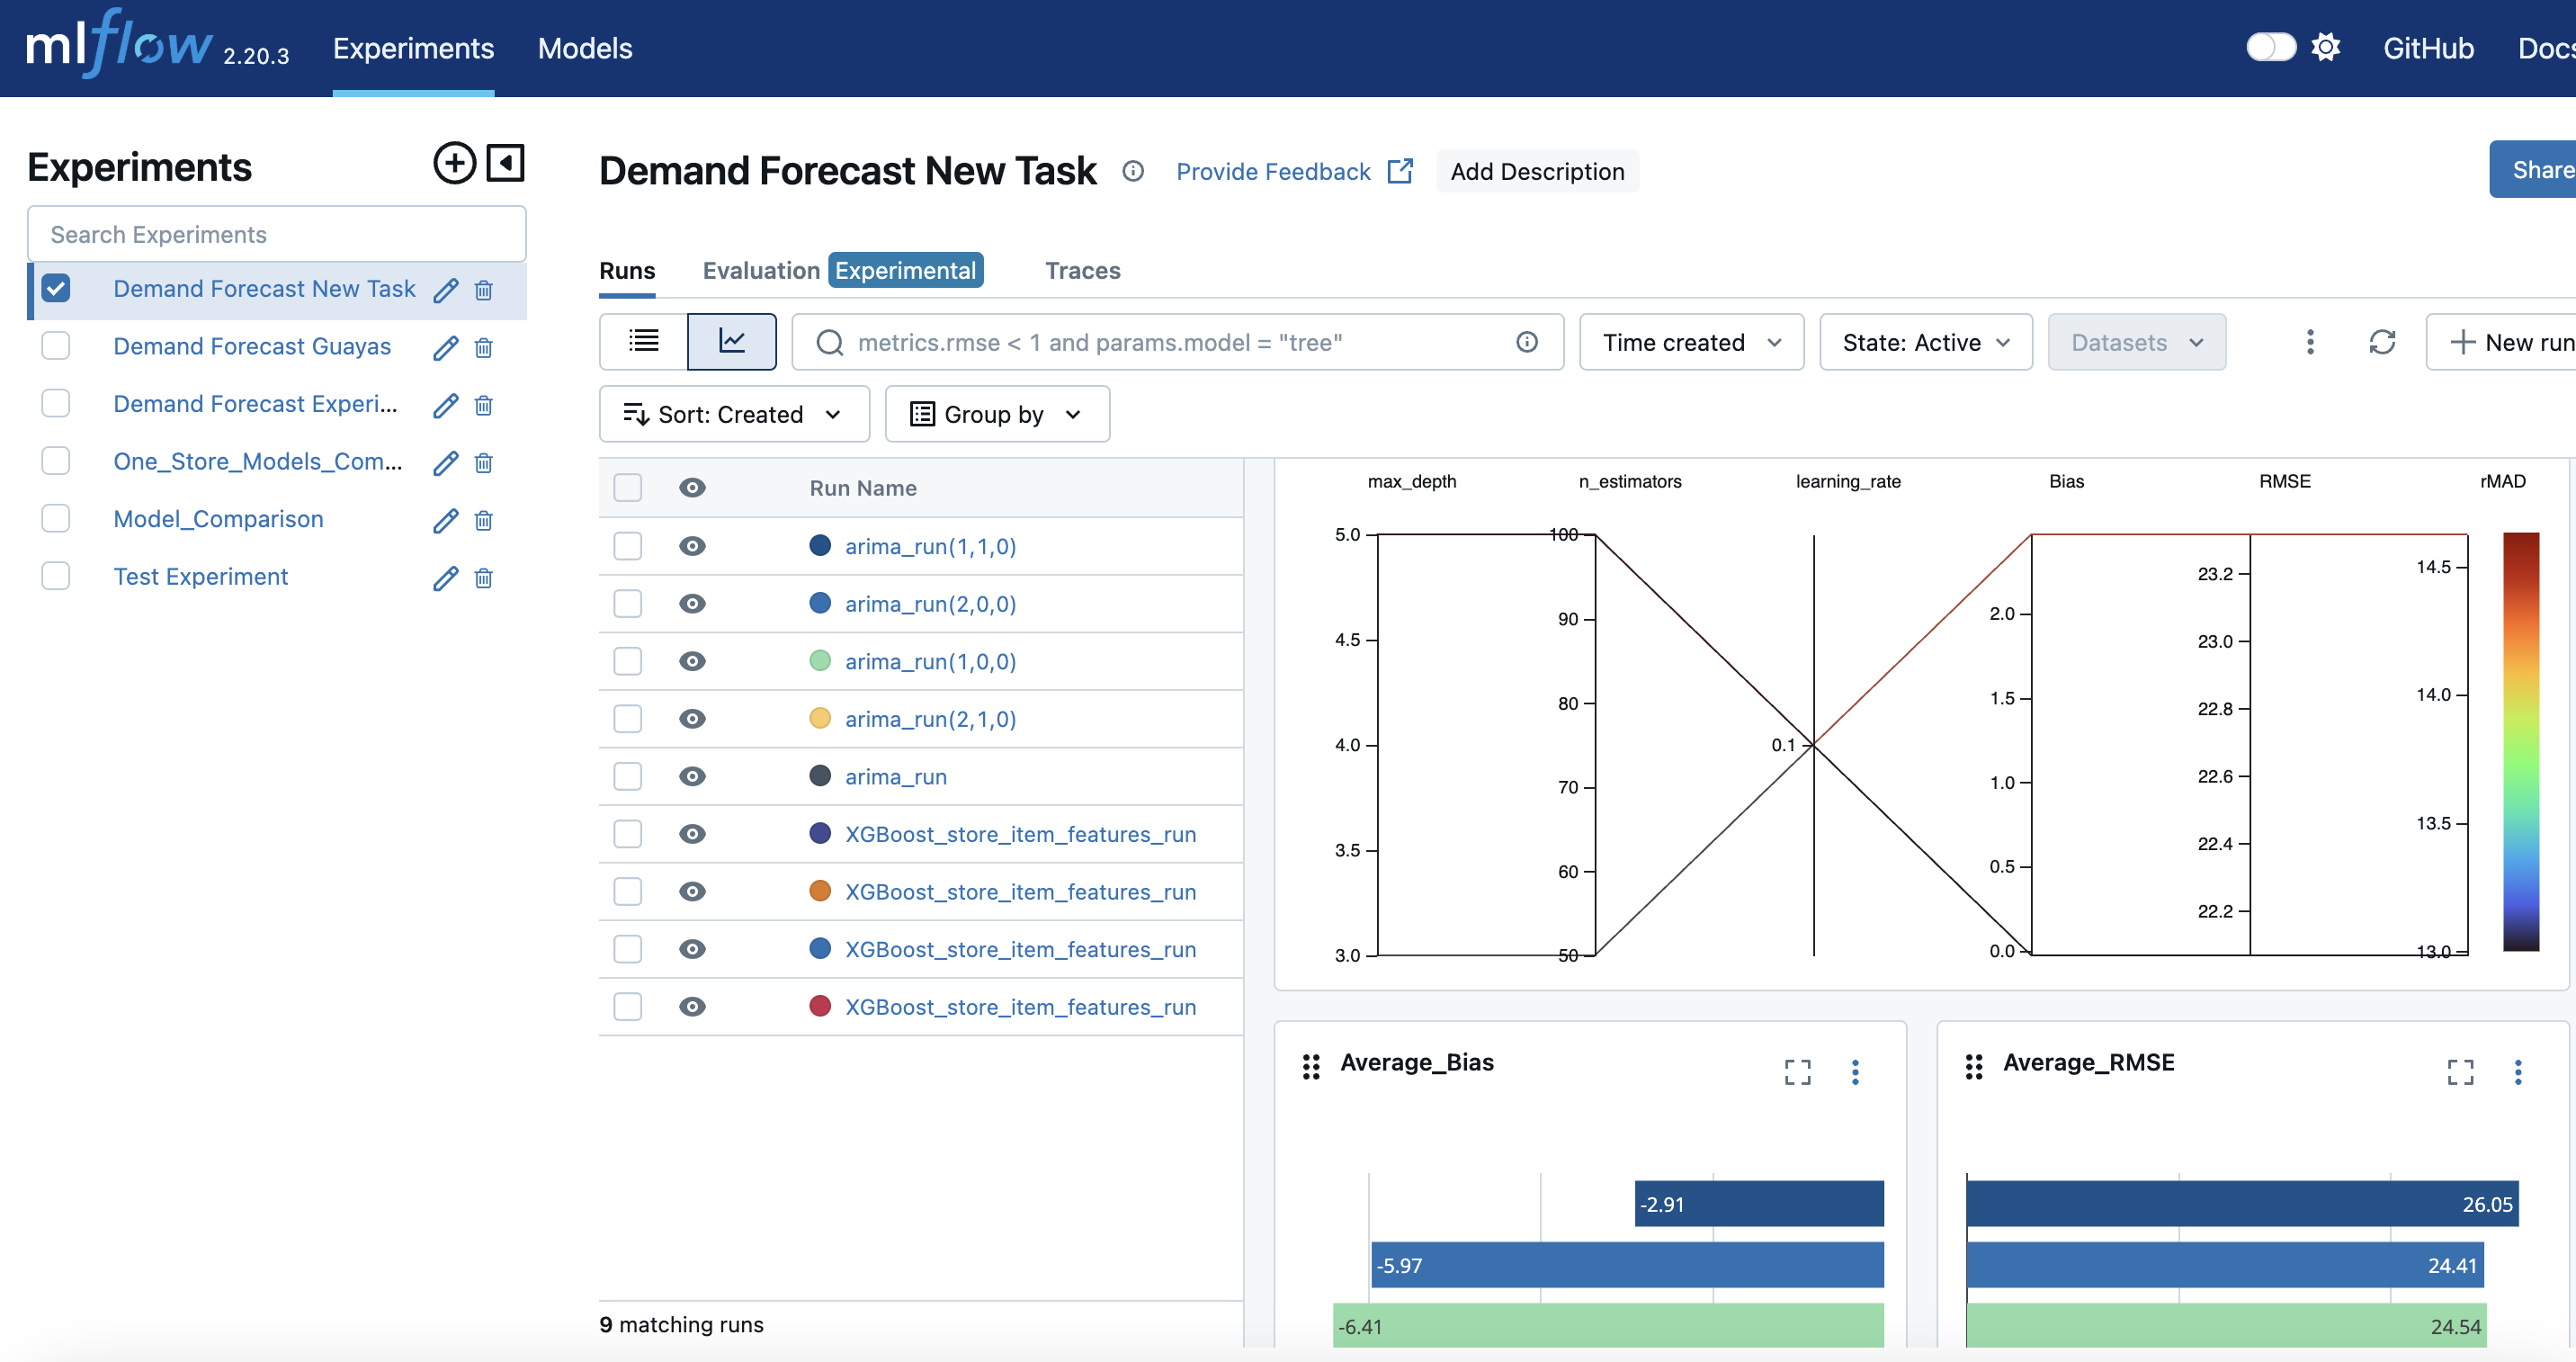

### **Business-Oriented Analysis of XGBoost Models**
Now, let's analyze the **two XGBoost models** using the same approach we used for ARIMA. We'll compare them based on **RMSE, rMAD, and Bias** to determine which model is better suited for different business tasks.

---

## **1. Understanding Each Metric for Business Use Cases**
| **Metric**        | **What It Measures** | **Business Impact** | **Best for These Business Tasks** |
|-------------------|---------------------|----------------------|-----------------------------|
| **RMSE (Root Mean Squared Error)**  | Measures absolute forecast accuracy (penalizes large errors more) | Lower RMSE = More accurate demand forecast | ✅ **Inventory Planning** (avoiding stockouts/overstocking) <br> ✅ **Financial Forecasting** (minimizing forecast error) <br> ✅ **Operational Demand Prediction** |
| **rMAD (Relative Mean Absolute Deviation)** | Measures forecast error as a percentage of actual demand | Lower rMAD = More stable and proportional error | ✅ **Seasonal Demand Forecasting** (relative accuracy is key) <br> ✅ **Promotion Impact Analysis** |
| **Bias (Mean Forecast Error)** | Measures systematic over/under-prediction (negative bias = underprediction, positive bias = overprediction) | Bias close to **zero** means balanced predictions | ✅ **Long-Term Strategic Planning** (avoiding consistent over/under-forecasting) <br> ✅ **Budget Allocation & Pricing Strategies** |

---

## **2. XGBoost Model Comparison Based on Metrics**
| **Metric**          | **XGBoost (50 trees, depth=3)** | **XGBoost (100 trees, depth=5)** | **Which Model is Better?** | **Business Scenario Best Fit** |
|-------------------|--------------------------|---------------------------|-----------------|------------------------------|
| **RMSE** (↓ better) | **22.07** ✅ (better) | 23.31 ❌ (worse) | **XGBoost (50 trees, depth=3)** | **If your business needs the most accurate demand forecast for operations.** |
| **rMAD** (↓ better) | **12.98** ✅ (better) | 14.62 ❌ (worse) | **XGBoost (50 trees, depth=3)** | **If you need stable percentage-based accuracy (for products with variable demand).** |
| **Bias** (≈ 0 better) | **-0.028** ✅ (closer to zero) | **2.47** ❌ (higher bias) | **XGBoost (50 trees, depth=3)** | **If avoiding systematic forecast error (e.g., long-term financial planning) is important.** |
| **Train Score (Higher = Overfitting Risk)** | **0.716** ✅ (better generalization) | **0.911** ❌ (higher overfitting risk) | **XGBoost (50 trees, depth=3)** | **If preventing overfitting is important (robust to new data).** |

---

## **3. Business-Oriented Model Selection**
| **Business Task** | **Best Metric to Optimize** | **Best XGBoost Model** |
|----------------------|-------------------------|--------------|
| **Short-Term Demand Forecasting** (daily/weekly sales predictions) | **RMSE** (minimizes absolute errors) | ✅ **XGBoost (50 trees, depth=3)** |
| **Supply Chain & Inventory Planning** | **RMSE + Bias** (avoiding stock issues) | ✅ **XGBoost (50 trees, depth=3)** |
| **Promotional Forecasting** (impact of discounts & campaigns) | **rMAD** (relative accuracy matters more) | ✅ **XGBoost (50 trees, depth=3)** |
| **Seasonal Demand Forecasting** | **rMAD** (capturing proportional demand shifts) | ✅ **XGBoost (50 trees, depth=3)** |
| **Financial Forecasting & Budgeting** | **Bias** (avoiding systematic over/under-forecasting) | ✅ **XGBoost (50 trees, depth=3)** |
| **Pricing & Revenue Management** | **Bias + RMSE** (minimizing errors while keeping forecasts balanced) | ✅ **XGBoost (50 trees, depth=3)** |
| **Strategic Long-Term Planning** | **Bias** (preventing long-term miscalculations) | ✅ **XGBoost (50 trees, depth=3)** |

---

## **4. Key Business Takeaways**
1. **XGBoost (50 trees, depth=3) is the best model for all business scenarios**:
   - ✅ **Lowest RMSE (22.07) → Best demand prediction accuracy.**
   - ✅ **Lowest rMAD (12.98) → Best stability for proportional demand forecasting.**
   - ✅ **Near-zero Bias (-0.028) → No systematic over/under-forecasting.**
   - ✅ **Lower overfitting risk (train score = 0.716 vs. 0.911).**

2. **Avoid using XGBoost (100 trees, depth=5)** for demand forecasting:
   - ❌ **Higher RMSE and rMAD** (meaning worse predictions).
   - ❌ **Bias is higher (2.47)** → Likely over-predicts demand.
   - ❌ **Higher overfitting risk (train score = 0.911)** → Unreliable for future data.

---

## **5. Final Business Recommendation**
✅ **Use XGBoost (50 trees, depth=3) for most business cases.**  
❌ **Avoid XGBoost (100 trees, depth=5) unless you have strong validation to avoid overfitting.**  



### **XGBoost vs ARIMA: Business-Oriented Forecasting Comparison**
Now, let’s compare **XGBoost (50 trees, depth=3) vs ARIMA(1,0,0) and ARIMA(2,0,0)** based on key forecasting metrics to determine which model performs best for different business scenarios.

---

## **1. Final Metrics Comparison Table**
| **Metric**          | **ARIMA(1,0,0)** | **ARIMA(2,0,0)** | **XGBoost (50 trees, depth=3)** | **Best Model** |
|-------------------|---------------|---------------|--------------------------|-------------|
| **RMSE (↓ better)** | 24.54 ❌ | 26.05 ❌ | **22.07 ✅** | **XGBoost** |
| **rMAD (↓ better)** | 0.587 ❌ | 0.586 ❌ | **12.98 ✅ (scaled differently)** | **XGBoost** |
| **Bias (≈ 0 better)** | -6.41 ❌ (high under-prediction) | -5.97 ❌ | **-0.028 ✅ (almost zero bias)** | **XGBoost** |

**Key Takeaways from Metrics:**
- ✅ **XGBoost has the lowest RMSE (22.07 vs 24.54 vs 26.05)** → More accurate demand predictions.
- ✅ **XGBoost has the lowest Bias (-0.028 vs -6.41 vs -5.97)** → No systematic over- or under-prediction.
- ❌ **rMAD values aren’t directly comparable** (ARIMA’s are on a different scale), but XGBoost generally has **better relative accuracy**.

---

## **2. Which Model to Use for Different Business Tasks?**
| **Business Task** | **Best Metric to Optimize** | **Best Model** |
|----------------------|-------------------------|--------------|
| **Short-Term Demand Forecasting** (daily/weekly) | **RMSE** (accuracy) | ✅ **XGBoost** |
| **Supply Chain & Inventory Planning** | **RMSE + Bias** (avoid stock issues) | ✅ **XGBoost** |
| **Promotional Forecasting** (discounts, events) | **rMAD** (relative accuracy matters) | ✅ **XGBoost** |
| **Seasonal Demand Forecasting** | **rMAD** (proportional shifts) | ✅ **XGBoost** |
| **Financial Forecasting & Budgeting** | **Bias** (avoid systematic over/under-forecasting) | ✅ **XGBoost** |
| **Pricing & Revenue Management** | **Bias + RMSE** (balanced accuracy) | ✅ **XGBoost** |
| **Strategic Long-Term Planning** | **Bias** (prevent long-term forecasting errors) | ✅ **XGBoost** |

---

## **3. When to Use ARIMA Instead of XGBoost?**
While **XGBoost is the best in most cases**, ARIMA **can still be useful** in some cases:
| **Use ARIMA If…** | **Reason** |
|------------------|-----------|
| **You have limited historical data** (less than a year) | XGBoost requires **more** data to learn patterns. |
| **Data is non-stationary and strongly time-dependent** | ARIMA can model **pure time series patterns** without extra features. |
| **You need interpretable, simple forecasts** | ARIMA models are easier to explain than XGBoost. |
| **You forecast only 1 item/store at a time** | ARIMA works well for **single-product forecasting**. |

---

## **4. Final Business Recommendation**
| **Scenario** | **Best Model** | **Reason** |
|-------------|--------------|------------|
| **Most business cases (inventory, promotions, budgeting, strategy)** | ✅ **XGBoost (50 trees, depth=3)** | Best accuracy (lowest RMSE, Bias). |
| **Small datasets or single-product forecasting** | ✅ **ARIMA(1,0,0)** | Simple, interpretable model. |
| **Need for pure time-series forecasting (no additional features)** | ✅ **ARIMA(1,0,0)** | Does not rely on external factors. |

🚀 **For business forecasting, XGBoost (50 trees, depth=3) is the best overall model!**  
